# An In-depth Exploration of US Job Market by analyzing LinkedIn Job Postings using Natural Language Processing Techniques

## Data ingestion and preprocesing
We firstly need to read the webscraped dataset and explore its contents before we begin the analysis.
For a better understanding of one domain we will focus on the jobs regarding the IT industry.

In [276]:
# Importing necessary libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import spacy
from ollama import chat
from pydantic import BaseModel, Field
from typing import List
import numpy as np
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA
from scipy.signal import find_peaks
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.manifold import TSNE
from torchtext.vocab import GloVe
from transformers import BertTokenizer, BertModel
import torch
from collections import Counter
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import nltk
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import log_loss, brier_score_loss
from scipy.stats import mode
from sklearn.decomposition import LatentDirichletAllocation
import ast
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import MinMaxScaler

In [18]:
# Read the dataset
data = pd.read_csv('/Users/juliabarsow/Desktop/thesis/project_code/postings.csv')

In [19]:
# Check how many descriptions are missing as this is the most important column
print("Missing rows of description: ",data['description'].isnull().sum())

# Drop rows with missing descriptions
data = data.dropna(subset=['description'])

Missing rows of description:  7


In [20]:
# List of titles to take into account in our project
titles_to_classify = [
    'Full Stack Engineer',
    'Java Architect',
    'Intern- Business Analytics',
    'Frontend Engineer',
    'Machine Learning Engineer',
    'Junior Project Manager',
    'Azure Data Engineer',
    'Sr. Project Engineer',
    'Junior Business Analyst',
    'Cloud / .NET Developer',
    'Enterprise Data & Analytics Infrastructure Manager',
    'Computer Scientist',
    'DevOps Engineer',
    'Front end specialist',
    'Project Engineer',
    'Data Architect',
    'Data Analyst',
    'Java architect / Lead Java developer',
    'Enterprise Data & Analytics Infrastructure Manager',
    'Senior Software Engineer',
    'Web Developer',
    'Software Implementation Program Manager',
    'Test Engineer',
    'Sr Software Engineer',
    'IT QA Engineer II',
    'Sr. Business Analyst/Tester',
    'Senior Developer – React Native',
    'Cloud DevOps Engineer',
    'Senior Analyst, Data & Analytics',
    'Senior Business Analyst',
    'Engineering Project Manager / Project Manager',
    'Java full Stack Engineer',
    'backend Java developer',
    'Data Science Software Engineer',
    'Data Engineer/ETL',
    'Business Analyst',
    'Data Scientist',
    'Cloud Architect'
]

# Filter the dataset to include only the specified titles
data = data[data['title'].isin(titles_to_classify)].reset_index(drop=True)

<Axes: title={'center': 'Job Title Distribution'}, xlabel='title'>

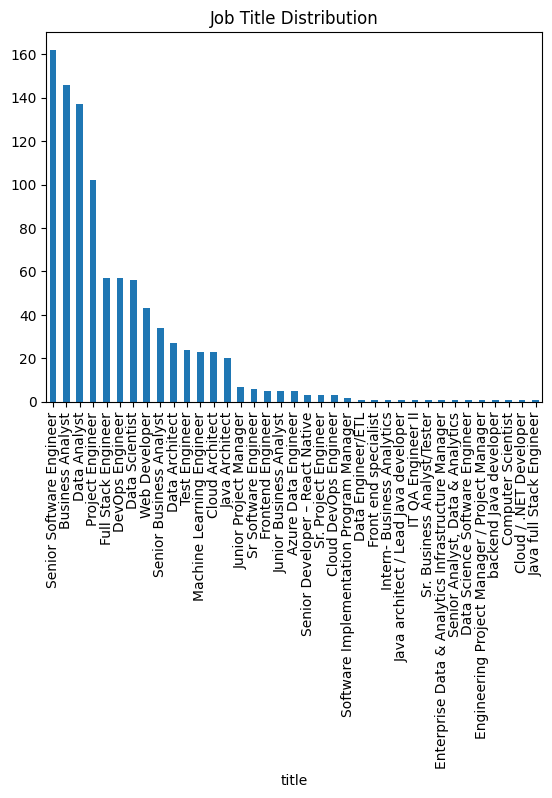

In [21]:
data['title'].value_counts().plot(kind='bar', title='Job Title Distribution')

In [22]:
# Make a copy of dataset for further processing and save only title and description columns
df = data.copy()
df = df[['job_id', 'title', 'description']]

In [23]:
def classify_job_titles(df: pd.DataFrame) -> pd.DataFrame:
    """
    Adds a new column 'general job classification' to a DataFrame based on 
    keywords found in the 'title' column.

    The classification logic applies rules in a specific order of precedence
    to handle complex or overlapping job titles.

    Args:
        df: The input pandas DataFrame containing a 'title' column.

    Returns:
        The modified DataFrame with the new 'general job classification' column.
    """
    if 'title' not in df.columns:
        print("Error: DataFrame must contain a 'title' column.")
        return df

    # Convert titles to lowercase for case-insensitive matching
    titles_lower = df['title'].str.lower().fillna('')

    # Use a function to apply classification rules with precedence
    def get_classification(title: str) -> str:
        """Determines the classification based on keywords in order of importance."""

        # 1. Project Management
        # Check for Program Manager or Project Manager/Engineer first
        if 'program manager' in title or 'project manager' in title or 'project engineer' in title:
            return 'Project Management'

        # 2. Data & Analytics 
        # Added 'scientist' to ensure 'Data Scientist' is caught here.
        if ('data' in title and ('engineer' in title or 'analyst' in title or 'architect' in title or 'scientist' in title)) or \
           'machine learning' in title or 'analytics' in title or 'etl' in title or 'data science' in title:
            return 'Data & Analytics'

        # 3. Business Analysis
        # This rule already catches 'Business Analyst' but remains here for explicit separation.
        if 'business analyst' in title:
            return 'Business Analysis'
        
        # 4. Technical Architecture 
        # This rule catches all 'architect' roles not already classified as Data Architect
        # (which is excluded here by Rule 2's high precedence over the 'architect' keyword alone).
        # We explicitly rely on this to catch 'Cloud Architect'.
        if 'architect' in title:
            return 'Technical Architecture'

        # 5. Software Development / Engineering (The catch-all for core tech roles)
        if 'software engineer' in title or 'developer' in title or 'devops' in title or \
           'full stack' in title or 'web developer' in title or 'frontend' in title or \
           'test engineer' in title or 'qa engineer' in title or 'computer scientist' in title or 'front end' in title:
            return 'Software Development / Engineering'

        # Default classification
        return 'Other/Unclassified'

    # Apply the classification function to the lowercase titles
    df['general job classification'] = titles_lower.apply(get_classification)
    
    return df

In [24]:
df = classify_job_titles(df)

<Axes: title={'center': 'Job Type Distribution'}, xlabel='general job classification'>

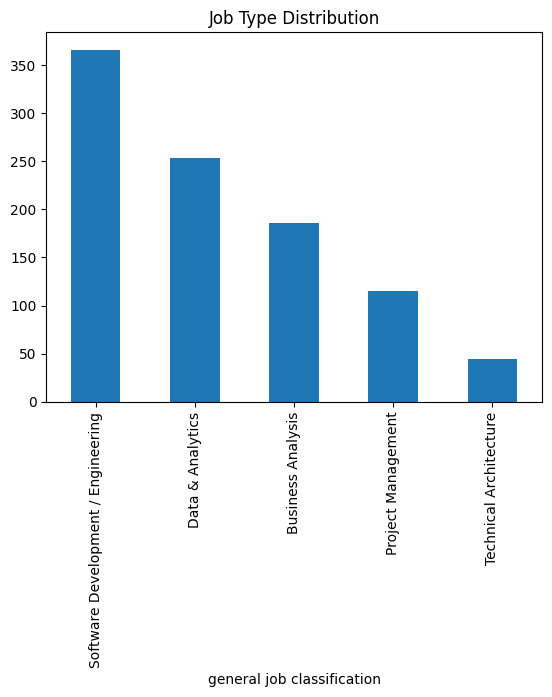

In [25]:
df['general job classification'].value_counts().plot(kind='bar', title='Job Type Distribution')

In [26]:
df['general job classification'].value_counts(normalize=True)

general job classification
Software Development / Engineering    0.379668
Data & Analytics                      0.262448
Business Analysis                     0.192946
Project Management                    0.119295
Technical Architecture                0.045643
Name: proportion, dtype: float64

In [27]:
# leave only unique job descriptions
df = df[~df['description'].duplicated(keep=False)]

In [28]:
df.shape

(840, 4)

## Skill Extraction and Clustering - Named entity recognition

#### Objective: Extract required skills from job descriptions and cluster them to identify common skill sets across industries.
#### We will use Ollama: https://ollama.com/ for the skill extraction

In [ ]:
# Run these commands in terminal to set up ollama and run the model
!pip install ollama
!python3 -m ollama pull llama3.2
!python3 -m ollama run granite3.2:8b

In [29]:
# Define the desired output structure using Pydantic
# This creates a JSON Schema that Ollama is forced to follow
class JobRequirements(BaseModel):
    """A structured model to hold the extracted skills and requirements from a job posting."""
    skills: List[str] = Field(
        ..., 
        description="A list of specific, technical, or soft skills required. E.g., 'Python', 'Machine Learning', 'Problem-Solving'."
    )
    requirements: List[str] = Field(
        ..., 
        description="A list of formal requirements, like years of experience, educational degrees, or specific certifications. E.g., 'Bachelor's Degree in Computer Science', '5+ years of experience with Kafka', 'AWS Certified'."
    )

In [30]:
# Define the prompt and configuration for Ollama
def extract_skills_requirements(job_post: str, model_name: str = "llama3.2") -> JobRequirements:
    """
    Sends the job posting to an Ollama model and extracts structured data.
    """
    
    # Generate the JSON schema from the Pydantic model
    schema = JobRequirements.model_json_schema()

    # The system prompt guides the model's behavior
    system_prompt = (
        "You are an expert HR data extraction bot. Your task is to accurately "
        "extract the required skills and formal requirements from the provided job posting. "
        "Do not include any commentary or additional text. "
        "The output MUST conform strictly to the provided JSON schema."
    )
    
    # The user prompt contains the data to be analyzed
    user_prompt = f"Analyze the following job posting and return the extracted data:\n\n---\n{job_post}"
    
    print(f"--- Sending request to Ollama with model: {model_name} ---")

    try:
        response = chat(
            model=model_name,
            messages=[
                {'role': 'system', 'content': system_prompt},
                {'role': 'user', 'content': user_prompt}
            ],
            # This is the key setting for structured output!
            format=schema,
            # Use temperature 0 for deterministic, reliable extraction
            options={'temperature': 0}
        )
        
        # The model's content is a JSON string conforming to the schema
        json_string = response['message']['content']
        
        # Validate and convert the JSON string back into a Pydantic object
        extracted_data = JobRequirements.model_validate_json(json_string) # TODO: prepusc head 5 linijek od poczatku do konca zeby sprawdzic czy ci sie procesuje
        
        return extracted_data

    except Exception as e:
        print(f"An error occurred: {e}")
        print("Ensure Ollama server is running and the model is pulled.") # TODO pydantic w collabie
        return None # TODO: WRZUCAJ DUZE ROBOTY CO SIE DLUGO PROCESUJA DO PIKLA

In [31]:
# Add extracted skills and formal requirements to the DataFrame
def append_skills_requirements(df: pd.DataFrame) -> pd.DataFrame:
    """
    Extracts skills and formal requirements from each job description in the DataFrame
    and appends them as new columns.

    Args:
        df: The input DataFrame with a 'description' column.

    Returns:
        The modified DataFrame with 'skills' and 'formal_requirements' columns.
    """
    skills_list = []
    requirements_list = []

    for i, job_posting_text in enumerate(df['description']):
        print(f"Processing row {i + 1}/{len(df)}...")
        result = extract_skills_requirements(job_posting_text)
        if result:
            skills_list.append(result.skills)
            requirements_list.append(result.requirements)
        else:
            skills_list.append([])  # Append empty list if extraction fails
            requirements_list.append([])

    # Add the extracted data as new columns
    df['skills'] = skills_list
    df['formal_requirements'] = requirements_list

    return df

In [32]:
df_skills = append_skills_requirements(df)

Processing row 1/840...
--- Sending request to Ollama with model: llama3.2 ---
Processing row 2/840...
--- Sending request to Ollama with model: llama3.2 ---
Processing row 3/840...
--- Sending request to Ollama with model: llama3.2 ---
Processing row 4/840...
--- Sending request to Ollama with model: llama3.2 ---
Processing row 5/840...
--- Sending request to Ollama with model: llama3.2 ---
Processing row 6/840...
--- Sending request to Ollama with model: llama3.2 ---
Processing row 7/840...
--- Sending request to Ollama with model: llama3.2 ---
Processing row 8/840...
--- Sending request to Ollama with model: llama3.2 ---
Processing row 9/840...
--- Sending request to Ollama with model: llama3.2 ---
Processing row 10/840...
--- Sending request to Ollama with model: llama3.2 ---
Processing row 11/840...
--- Sending request to Ollama with model: llama3.2 ---
Processing row 12/840...
--- Sending request to Ollama with model: llama3.2 ---
Processing row 13/840...
--- Sending request to O

In [33]:
# make a pickle out of the output of previous cell code
import pickle
file_path = 'df_skills.pkl'

# Save the DataFrame to a pickle file
df_skills.to_pickle(file_path)

## Skill word embedding and clustering

In terminal/command line - Install and load the SpaCy model: python -m spacy download en_core_web_lg 

In [296]:
# Explode the list column into individual rows, keeping the index
# Convert all skills to lowercase for standardization
# Drop missing/empty values (if any)
unique_skills_series = df_skills['skills'].explode().str.lower().dropna().drop_duplicates()
unique_skills_list = unique_skills_series.tolist()

# # Filter out very rare, noisy skills
# # Only keep skills that appear in at least 3 job postings
# skill_counts = df_skills['skills'].explode().str.lower().value_counts()
# frequent_skills = skill_counts[skill_counts >= 3].index.tolist()
# unique_skills_list = [skill for skill in unique_skills_list if skill in frequent_skills] # TODO: bierz pod uwage wszystkie skille

print(f"Number of skills to cluster: {len(unique_skills_list)}")

Number of skills to cluster: 3898


In [297]:
unique_skills_list[:10]  # Display the first 10 unique skills

['full-stack web development',
 'javascript/typescript',
 'react',
 'node.js',
 'python',
 'express.js',
 'relational databases',
 'nosql databases',
 'html5',
 'css3']

### First embedding approach - SpaCy Vector

Fast Vector Generation (Low Computational Cost).
This is the fastest step. SpaCy simply looks up the pre-computed vector for each skill.
Generate a vector for every unique skill.

In [298]:
# Load the model with vectors
nlp = spacy.load("en_core_web_lg")

In [299]:
# Use a list comprehension to get the vector for each skill
# .vector provides the 300-dimensional vector from the en_core_web_lg model
skill_vectors = np.array([nlp(skill).vector for skill in unique_skills_list])

In [300]:
def find_elbow_point(k_values, inertia_values):
    """
    Identifies the elbow point in the inertia curve using the maximum second derivative method.

    Args:
        k_values: List of K values.
        inertia_values: Corresponding inertia values for each K.

    Returns:
        int or None: The K value at the elbow point.
    """
    # Calculate the second derivative of inertia values
    second_derivative = np.diff(inertia_values, n=2)

    # Find peaks in the second derivative (elbow points)
    peaks, _ = find_peaks(-second_derivative)  # Negative because we want maxima in the original curve

    if len(peaks) > 0:
        elbow_k = k_values[peaks[0] + 1]  # +1 to account for the diff reducing the array size
        return elbow_k
    else:
        return None

In [301]:
def plot_elbow_curve(vectors, k_range=range(2, 25)):
    """
    Plots the Elbow Curve for K-Means clustering and identifies the optimal number of clusters.

    Args:
        skill_vectors (ndarray): The input data to cluster.
        k_range (range): The range of K values to test.

    Returns:
        int or None: The optimal number of clusters (K) if detected, otherwise None.
    """
    inertia = []

    # Calculate inertia for each K
    for k in k_range:
        kmeans = KMeans(n_clusters=k, random_state=42)
        kmeans.fit(vectors)
        inertia.append(kmeans.inertia_)

    # Plot the Elbow Curve
    plt.figure(figsize=(10, 6))
    plt.plot(k_range, inertia, marker='o', linestyle='--')
    plt.title('Elbow Method for Optimal K')
    plt.xlabel('Number of Clusters (K)')
    plt.ylabel('Inertia (Within-Cluster Sum of Squares)')
    plt.xticks(k_range[::2])  # Show every second tick mark for clarity
    plt.grid(True)

    elbow_k = find_elbow_point(list(k_range), inertia)
    if elbow_k:
        print(f"Elbow point detected at K = {elbow_k}")
        plt.axvline(x=elbow_k, color='r', linestyle='--', label=f'Elbow at K={elbow_k}')
        plt.legend()
    else:
        print("No clear elbow point detected.")
    plt.show()

    return elbow_k

In [302]:
def plot_silhouette_scores(skill_vectors, k_range=range(2, 25)):
    """
    Plots the Silhouette Score for K-Means clustering to help determine the optimal number of clusters.

    Args:
        skill_vectors (ndarray): The input data to cluster.
        k_range (range): The range of K values to test.

    Returns:
        dict: A dictionary with K values as keys and their corresponding Silhouette Scores as values.
    """
    silhouette_scores = {}

    # Calculate Silhouette Score for each K
    for k in k_range:
        kmeans = KMeans(n_clusters=k, random_state=42).fit(skill_vectors)
        labels = kmeans.predict(skill_vectors)
        silhouette_scores[k] = silhouette_score(skill_vectors, labels)

    # Plot the Silhouette Scores
    plt.figure(figsize=(10, 6))
    plt.plot(list(silhouette_scores.keys()), list(silhouette_scores.values()), 'bx-')
    plt.xlabel("Number of clusters")
    plt.ylabel("Silhouette Score")
    plt.title('Silhouette Score Method for Optimal K')
    plt.grid(True)
    plt.xticks(list(k_range)[::2])  # Show every second tick mark for clarity
    plt.show()

    return silhouette_scores

Elbow point detected at K = 5


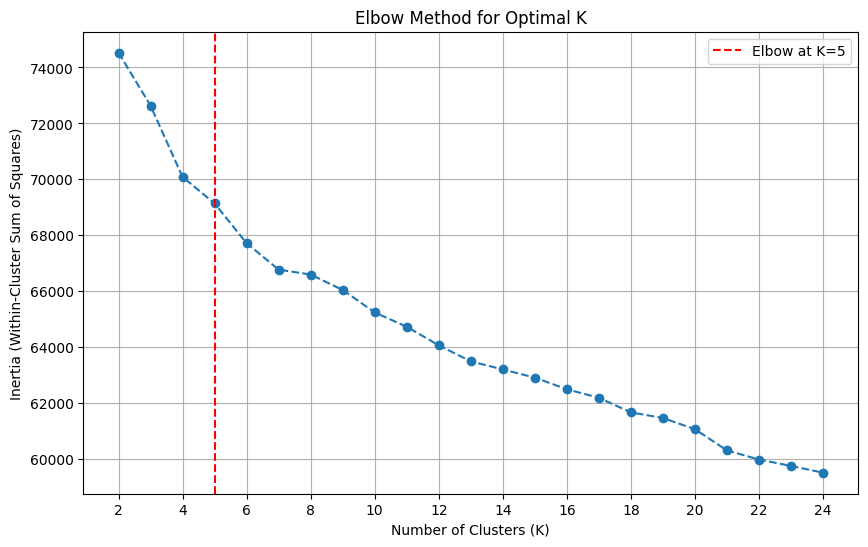

Optimal number of clusters: 5


In [303]:
# Elbow plot for optimal number of clusters
optimal_k = plot_elbow_curve(skill_vectors)
print(f"Optimal number of clusters: {optimal_k}")

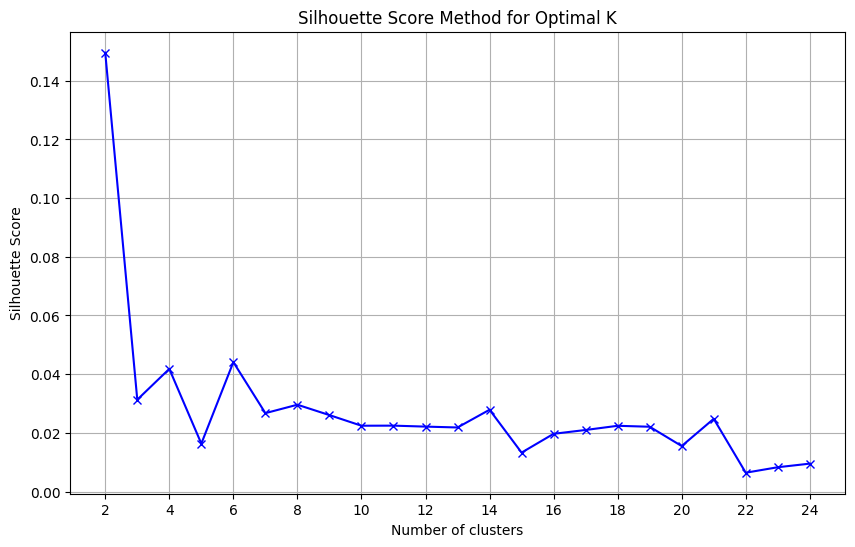

{2: 0.1495683640241623, 3: 0.03130649775266647, 4: 0.04180965572595596, 5: 0.016328690573573112, 6: 0.044107601046562195, 7: 0.026715591549873352, 8: 0.029589036479592323, 9: 0.026050306856632233, 10: 0.022428372874855995, 11: 0.022458061575889587, 12: 0.022125929594039917, 13: 0.021831698715686798, 14: 0.027875231578946114, 15: 0.013266933150589466, 16: 0.01967397890985012, 17: 0.02097872458398342, 18: 0.022405382245779037, 19: 0.022082587704062462, 20: 0.015501122921705246, 21: 0.024789171293377876, 22: 0.006409040652215481, 23: 0.008280575275421143, 24: 0.009506212547421455}


In [304]:
# Plot silhouette scores to help determine optimal K for vectors
silhouette_scores = plot_silhouette_scores(skill_vectors)
print(silhouette_scores)

In [305]:
def perform_kmeans_clustering(skill_vectors, unique_skills_list, K, random_state=42):
    """
    Performs K-Means clustering on the given skill vectors and calculates metrics.

    Args:
        skill_vectors (ndarray): The input data to cluster.
        unique_skills_list (list): List of unique skills corresponding to the vectors.
        K (int): The number of clusters.
        random_state (int): Random state for reproducibility. Default is 42.

    Returns:
        tuple: A tuple containing:
            - cluster_labels (ndarray): Cluster labels for each skill vector.
            - inertia_value (float): Inertia value for the chosen K.
            - sc_score (float): Silhouette score for the chosen K.
            - skill_to_cluster_id (pd.Series): Mapping of skills to their cluster IDs.
    """
    # Initialize and fit the KMeans model
    kmeans = KMeans(n_clusters=K, random_state=random_state, init='k-means++', n_init='auto')
    cluster_labels = kmeans.fit_predict(skill_vectors)

    # Calculate inertia and silhouette score
    inertia_value = kmeans.inertia_
    sc_score = silhouette_score(skill_vectors, cluster_labels)

    # Mapping skill to its cluster ID
    skill_to_cluster_id = pd.Series(cluster_labels, index=unique_skills_list)

    # Print metrics
    print(f"Inertia for K={K}: {inertia_value}")
    print(f"Silhouette Score for K={K}: {sc_score}")

    return cluster_labels, inertia_value, sc_score, skill_to_cluster_id

In [306]:
# Perform clustering and get results
cluster_labels, inertia_value, sc_score, skill_to_cluster_id_spacy = perform_kmeans_clustering(skill_vectors, unique_skills_list, K=6)

Inertia for K=6: 67719.328125
Silhouette Score for K=6: 0.044107601046562195


In [307]:
def print_clusters_and_skills(skill_to_cluster_id, K):
    """
    Prints the clusters and their associated skills.

    Args:
        skill_to_cluster_id (pd.Series): A mapping of skills to their cluster IDs.
        K (int): The number of clusters.

    Returns:
        None
    """
    for cluster_id in range(K):
        print(f"Cluster {cluster_id}:")
        cluster_skills = [skill for skill, cluster in skill_to_cluster_id.items() if cluster == cluster_id]
        print(", ".join(cluster_skills))
        print("-" * 50)

In [308]:
print_clusters_and_skills(skill_to_cluster_id_spacy, K=6)

Cluster 0:
javascript/typescript, python, nosql databases, html5, azure, microsoft excel, sql, json, java, rest api, micro frontend, typescript/javascript, postgresql, javascript, php, html, css, git, mysql, apache, core java, scripting (powershell), linux, maven, pl/sql, ppt, excel, github actions, shell scripting, azure sql server, sql queries, sql reporting, c++, branch versioning, wpf ui framework, sql server, oracle, asp.net mvc or webforms, postgres, java development, nginx, tomcat, api platforms, etl tools, snowflake database, autodesk autocad, esri software, esri arcgis software, autocad, django framework, abap development, ldap, matlab, context api, node, django, hibernate, apache struts, restful api, magento, jquery, ios, android, adobe xd, android studio ide, xml, android sdk, sqlite, powershell, asp.net mvc, asp.net core, mvc, ios sdk, mongo db, ruby, powerpoint, vba, microsoft .net framework, asp.net, vb.net, c/c++, apache iceberg, sap, microsoft office, database platforms

In [309]:
# Map each skill to its cluster label
def map_skills_to_clusters(skills_list, skill_to_cluster_id):
    return [skill_to_cluster_id.get(skill) for skill in skills_list if skill in skill_to_cluster_id]

In [310]:
df_clustered_spacy = df_skills.copy()
# df_clustered_spacy['skill_cluster_ids'] = df_clustered_spacy['skills'].apply(map_skills_to_clusters)

df_clustered_spacy['skill_cluster_ids'] = df_clustered_spacy['skills'].apply(
    lambda skills_list: map_skills_to_clusters(skills_list, skill_to_cluster_id_spacy)
)

In [311]:
# Print cluster IDs for each general job classification
classification_clusters = df_clustered_spacy.groupby('general job classification')['skill_cluster_ids'].apply(
    lambda x: set(cluster_id for cluster_list in x for cluster_id in cluster_list if cluster_list)
)

for classification, clusters in classification_clusters.items():
    print(f"General Job Classification: {classification}")
    print(f"Cluster IDs: {sorted(clusters)}")
    print("-" * 50)

General Job Classification: Business Analysis
Cluster IDs: [np.int32(1), np.int32(2), np.int32(3), np.int32(4), np.int32(5)]
--------------------------------------------------
General Job Classification: Data & Analytics
Cluster IDs: [np.int32(0), np.int32(1), np.int32(2), np.int32(3), np.int32(4), np.int32(5)]
--------------------------------------------------
General Job Classification: Project Management
Cluster IDs: [np.int32(1), np.int32(2), np.int32(3), np.int32(4), np.int32(5)]
--------------------------------------------------
General Job Classification: Software Development / Engineering
Cluster IDs: [np.int32(0), np.int32(1), np.int32(2), np.int32(3), np.int32(4), np.int32(5)]
--------------------------------------------------
General Job Classification: Technical Architecture
Cluster IDs: [np.int32(1), np.int32(2), np.int32(3), np.int32(4), np.int32(5)]
--------------------------------------------------


In [312]:
def plot_cluster_heatmap(df_clustered, figsize=(12, 8), cmap="YlGnBu"):
    """
    Plots a heatmap showing the proportional frequency of cluster IDs in each general job classification.

    Args:
        df_clustered (pd.DataFrame): The DataFrame containing 'general job classification' and 'skill_cluster_ids'.
        figsize (tuple): The size of the heatmap figure (default is (12, 8)).
        cmap (str): The colormap for the heatmap (default is "YlGnBu").

    Returns:
        None
    """
    cluster_frequency = df_clustered.explode('skill_cluster_ids') \
                                     .groupby(['general job classification', 'skill_cluster_ids']) \
                                     .size() \
                                     .unstack(fill_value=0)

    # 2. Normalize the counts row-wise (i.e., by 'general job classification')
    # This converts the counts into proportions (percentages) within each row.
    cluster_proportion = cluster_frequency.div(cluster_frequency.sum(axis=1), axis=0)

    # 3. Plot the heatmap using the proportions
    plt.figure(figsize=figsize)
    # Set annot=True to show the actual proportion values on the heatmap (optional)
    # Use fmt=".2f" to format proportions to two decimal places if annot=True
    sns.heatmap(cluster_proportion, annot=False, cmap=cmap, cbar=True, linewidths=0.5)

    plt.title("Proportional Frequency of Cluster IDs in General Job Classifications", fontsize=14)
    plt.xlabel("Cluster ID", fontsize=12)
    plt.ylabel("General Job Classification", fontsize=12)
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

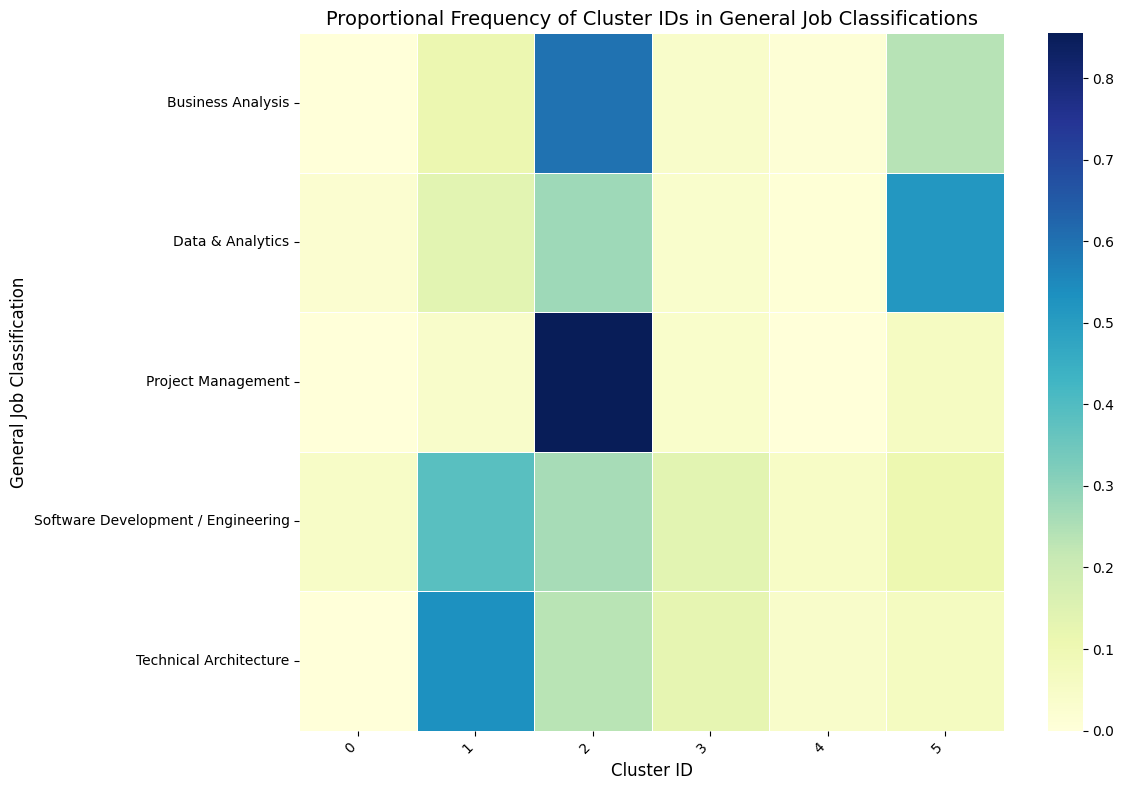

In [313]:
plot_cluster_heatmap(df_clustered_spacy)

In [314]:
def reduce_dimensionality_pca(vectors: np.ndarray, cluster_labels: np.ndarray) -> pd.DataFrame:
    """
    Reduces the dimensionality of the given vectors to 2D using PCA.

    Args:
        vectors (ndarray): The input high-dimensional vectors.

    Returns:
        ndarray: The 2D reduced vectors.
    """
    pca = PCA(n_components=2, random_state=42)
    reduced_vectors = pca.fit_transform(vectors)

    # Create a DataFrame for easy plotting
    pca_df = pd.DataFrame(reduced_vectors, columns=['PC1', 'PC2'])
    # Add the cluster labels to the DataFrame
    pca_df['Cluster'] = cluster_labels

    return pca_df

In [315]:
pca_df = reduce_dimensionality_pca(skill_vectors, cluster_labels)

In [316]:
def plot_2d_clusters_pca(df_to_plot: pd.DataFrame, k_clusters: int):
    """
    Generates a scatter plot to visualize clusters in a 2D space (PCA).

    Args:
        df_to_plot (pd.DataFrame): DataFrame containing the 2D coordinates 
                                   (first two columns) and cluster labels.
        k_clusters (int): The number of clusters (K) found by the clustering algorithm.
    """

    # Check for required columns
    if len(df_to_plot.columns) < 2 or 'Cluster' not in df_to_plot.columns:
        print(f"Error: DataFrame must have at least two coordinate columns and a 'Cluster' column.")
        return

    # --- Setup and Scatter Plot ---
    plt.figure(figsize=(10, 8))
    
    # Create the scatter plot
    scatter = plt.scatter(
        df_to_plot.iloc[:, 0], 
        df_to_plot.iloc[:, 1],
        c=df_to_plot['Cluster'], 
        cmap='tab20',
        s=50,          # Marker size
        alpha=0.6      # Transparency
    )

    # --- Title and Labels ---
    # Use the inferred reduction method in the title
    title = f'K-Means Clusters (K={k_clusters}) visualized with PCA'
    plt.title(title, fontsize=16)
    
    plt.xlabel(df_to_plot.columns[0], fontsize=12)
    plt.ylabel(df_to_plot.columns[1], fontsize=12)

    # --- Legend and Final Touches ---
    # Add a legend
    legend1 = plt.legend(
        *scatter.legend_elements(),
        title="Cluster ID",
        loc="upper right" 
    )
    plt.gca().add_artist(legend1)

    plt.grid(True, linestyle='--', alpha=0.6) 
    plt.show()

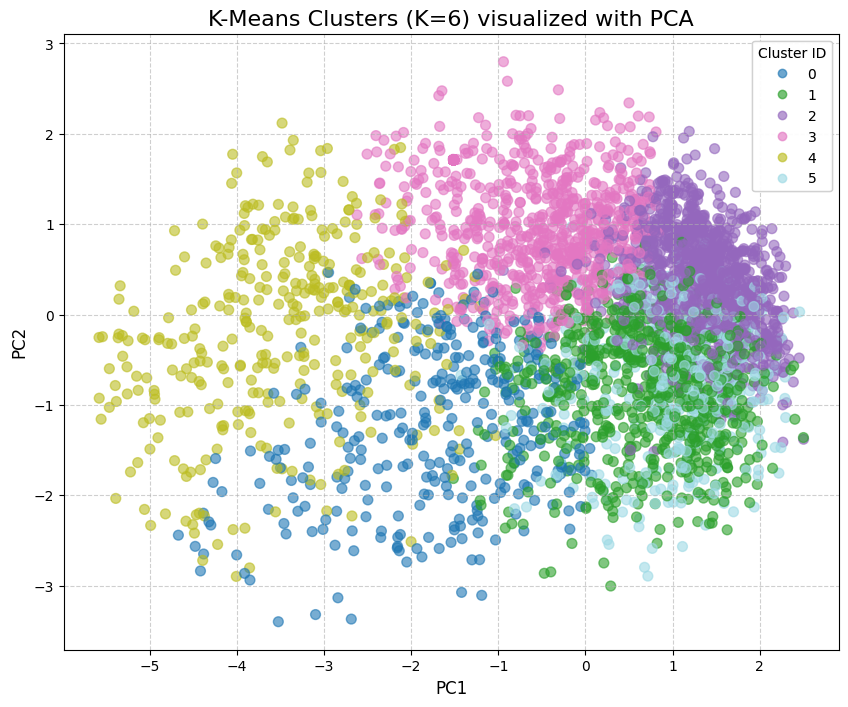

In [317]:
plot_2d_clusters_pca(df_to_plot=pca_df, k_clusters=6)

### Second embedding approach - TF-IDF Vectorization

In [318]:
# Use the already prepared unique_skills_list
print(f"Number of unique skills to vectorize: {len(unique_skills_list)}")

# Vectorize the skills using TF-IDF
vectorizer = TfidfVectorizer(sublinear_tf=True, min_df=5, max_df=0.95)  # Adjust min_df/max_df as needed
tfidf_matrix = vectorizer.fit_transform(unique_skills_list).toarray()


Number of unique skills to vectorize: 3898


Elbow point detected at K = 5


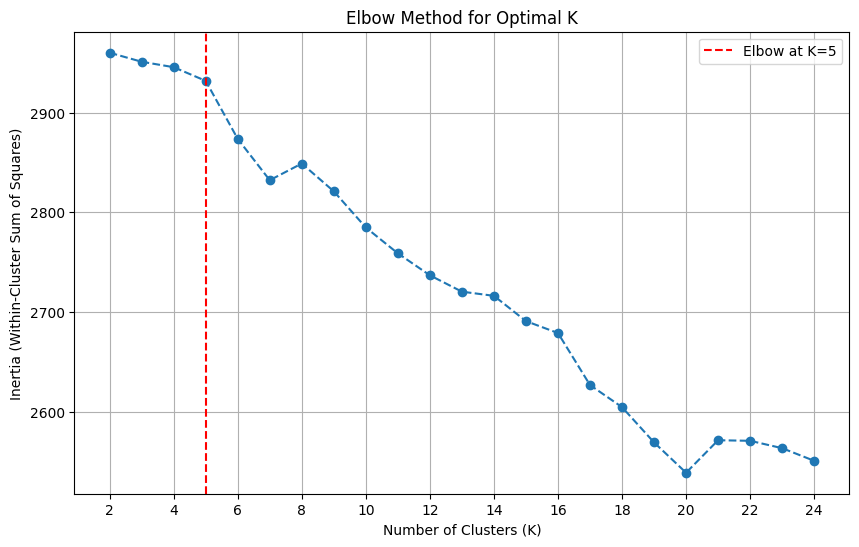

Optimal number of clusters (TF-IDF): 5


In [319]:
# elbow plot for optimal number of clusters
optimal_k_tfidf = plot_elbow_curve(tfidf_matrix)
print(f"Optimal number of clusters (TF-IDF): {optimal_k_tfidf}")

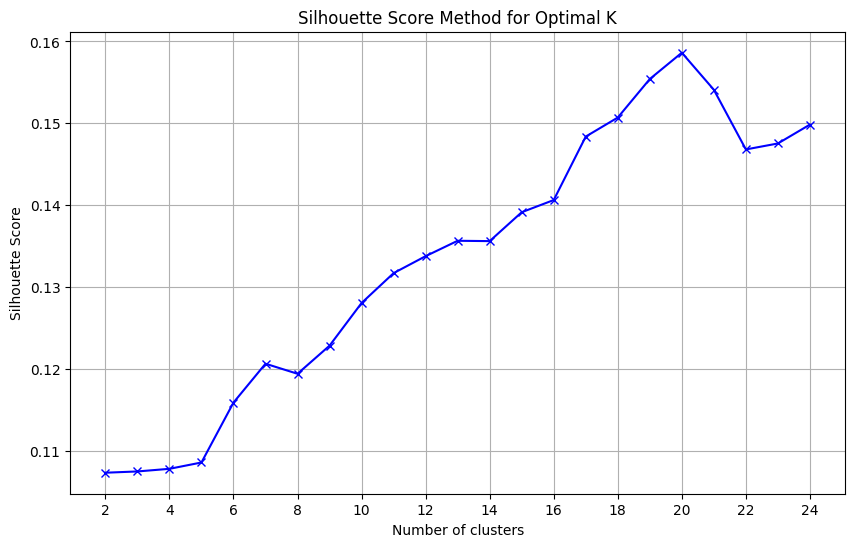

{2: 0.10735368372149154, 3: 0.10750921274356508, 4: 0.10782980733223615, 5: 0.10860336566511615, 6: 0.11591533991448819, 7: 0.12065877477533439, 8: 0.11943238356889462, 9: 0.12286274314840626, 10: 0.1280713145807108, 11: 0.1317171138971518, 12: 0.13378761265602968, 13: 0.1356654455593723, 14: 0.13562355493600187, 15: 0.13914963318943407, 16: 0.14063765330816852, 17: 0.14838566435819622, 18: 0.15070675141401021, 19: 0.15541121601289576, 20: 0.15861927589865787, 21: 0.15409917323721067, 22: 0.14681454440512526, 23: 0.14754247225728445, 24: 0.1498475713767478}


In [320]:
# silhouette plot for optimal number of clusters
silhouette_scores_tfidf = plot_silhouette_scores(tfidf_matrix)
print(silhouette_scores_tfidf)

In [321]:
# perform clustering and get results
cluster_labels_tfidf, inertia_value, sc_score, skill_to_cluster_id_tfidf = perform_kmeans_clustering(tfidf_matrix, unique_skills_list, K=6)

Inertia for K=6: 2873.5680974446805
Silhouette Score for K=6: 0.11591533991448819


In [322]:
print_clusters_and_skills(skill_to_cluster_id_tfidf, K=6)

Cluster 0:
full-stack web development, javascript/typescript, react, node.js, python, express.js, relational databases, nosql databases, html5, css3, responsive design principles, cloud platforms, aws, azure, google cloud platform, software engineering best practices, version control, testing, software development, deep space communication, navigation systems, mobile application development, phone sales, customer service, interpersonal skills, quality work ethic, exceptional communication, organizational skills, multitasking, attention to detail, modeling, visualization, microsoft excel, tableau, power bi, construction/civil engineering, architecture, project management, ec2, s3, lambda, glue, athena, kinesis, etl, sql, redshift, spark, json, security, java, microservices, rest api, web services, ui - react js, redux, micro frontend, typescript, react.js, analytics, team management, infrastructure support, stability, innovative product launch, smb and consumer tools, golang, gcp, types

In [323]:
df_clustered_tfidf = df_skills.copy()
# df_clustered_tfidf['skill_cluster_ids'] = df_clustered_tfidf['skills'].apply(map_skills_to_clusters)

df_clustered_tfidf['skill_cluster_ids'] = df_clustered_tfidf['skills'].apply(
    lambda skills_list: map_skills_to_clusters(skills_list, skill_to_cluster_id_tfidf)
)

In [324]:
# Print cluster IDs for each general job classification
classification_clusters = df_clustered_tfidf.groupby('general job classification')['skill_cluster_ids'].apply(
    lambda x: set(cluster_id for cluster_list in x for cluster_id in cluster_list if cluster_list)
)

for classification, clusters in classification_clusters.items():
    print(f"General Job Classification: {classification}")
    print(f"Cluster IDs: {sorted(clusters)}")
    print("-" * 50)

General Job Classification: Business Analysis
Cluster IDs: [np.int32(0), np.int32(1), np.int32(4), np.int32(5)]
--------------------------------------------------
General Job Classification: Data & Analytics
Cluster IDs: [np.int32(0), np.int32(1), np.int32(4), np.int32(5)]
--------------------------------------------------
General Job Classification: Project Management
Cluster IDs: [np.int32(0), np.int32(1), np.int32(5)]
--------------------------------------------------
General Job Classification: Software Development / Engineering
Cluster IDs: [np.int32(0), np.int32(2), np.int32(3), np.int32(4), np.int32(5)]
--------------------------------------------------
General Job Classification: Technical Architecture
Cluster IDs: [np.int32(0), np.int32(4), np.int32(5)]
--------------------------------------------------


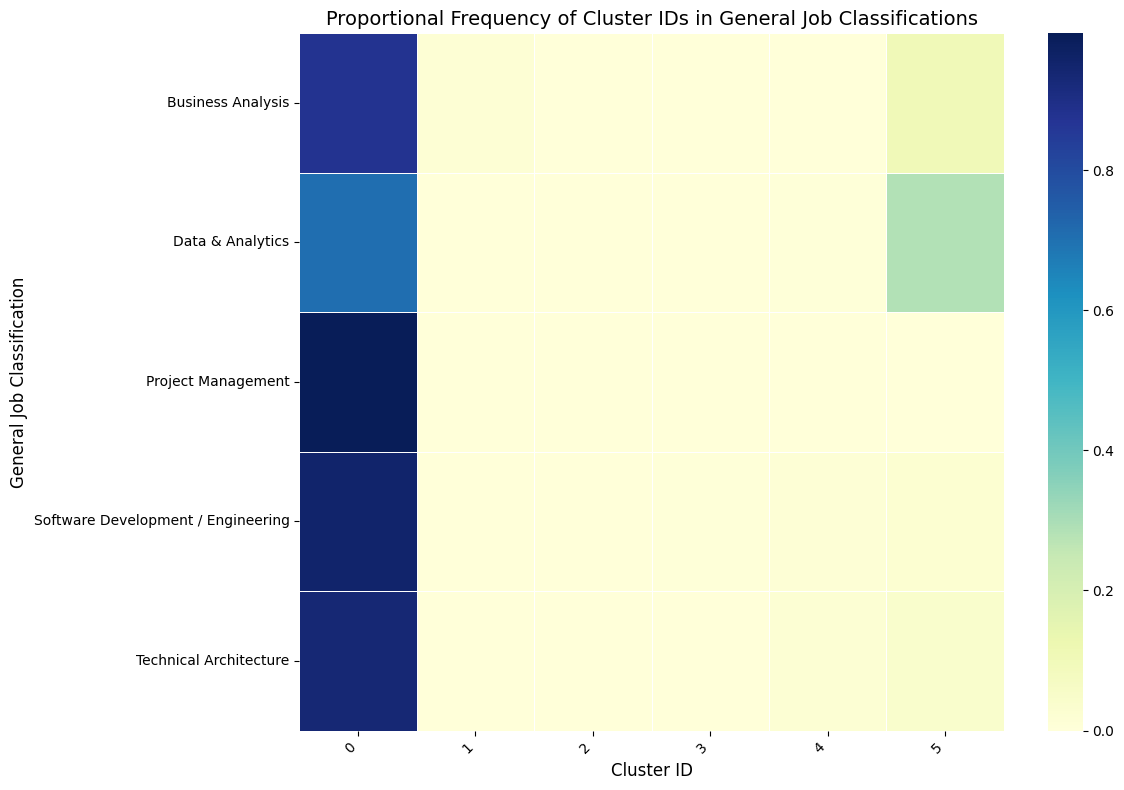

In [325]:
plot_cluster_heatmap(df_clustered_tfidf) # TODO: CLUSTER THE CLUSTER !!! CLUSTER 0 CLUSTER

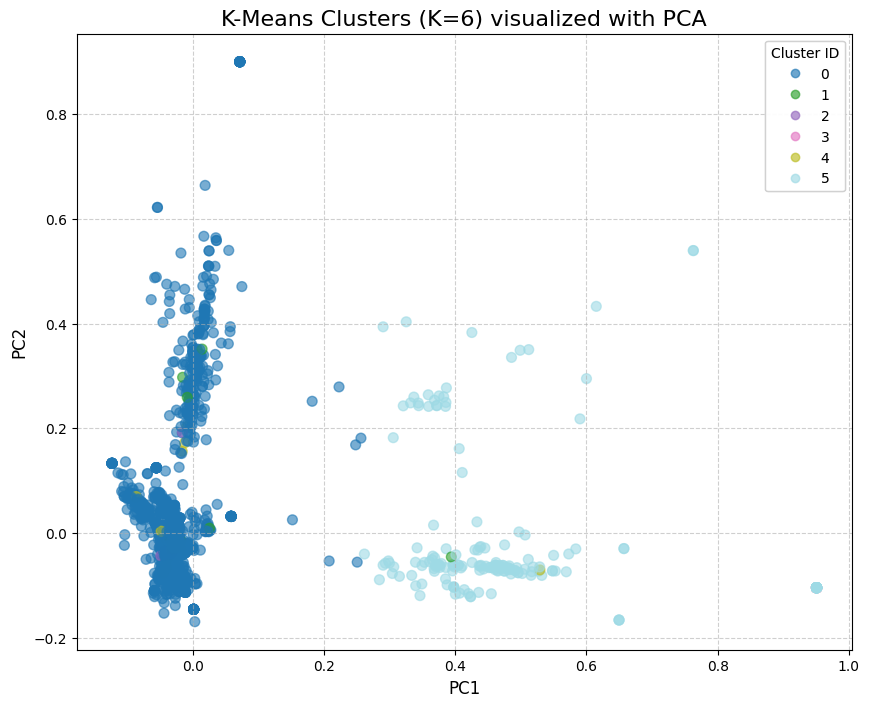

In [326]:
pca_df = reduce_dimensionality_pca(tfidf_matrix, cluster_labels_tfidf)
plot_2d_clusters_pca(df_to_plot=pca_df, k_clusters=6)


Starting t-SNE reduction. This may take a moment...
t-SNE reduction complete.


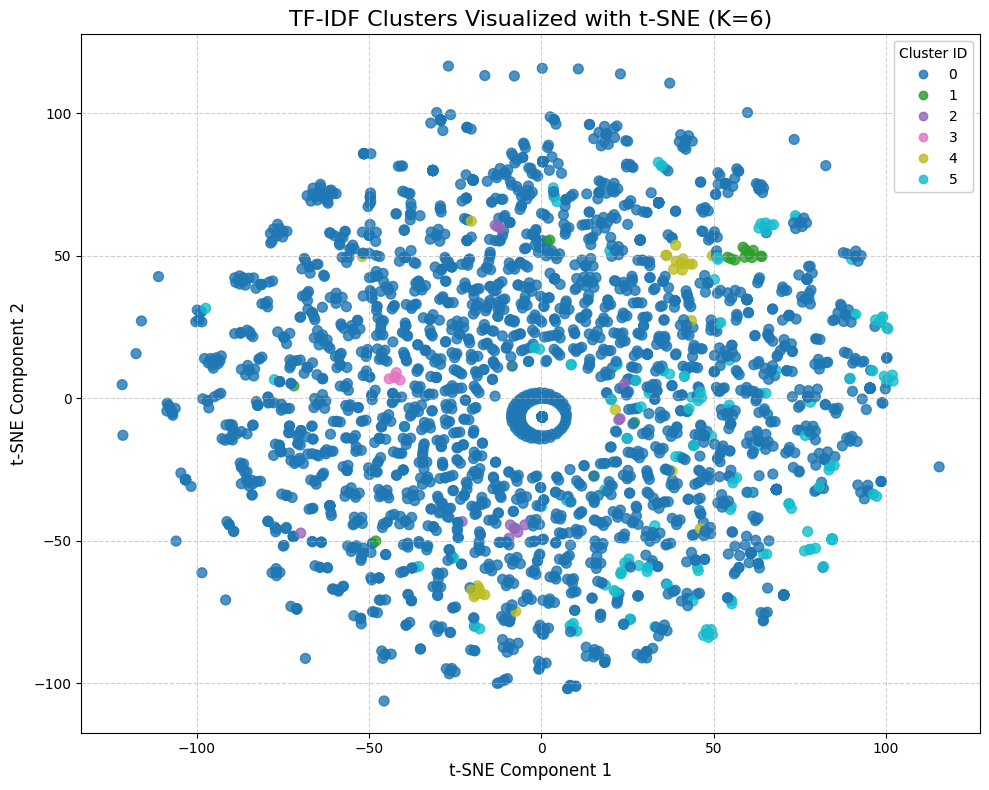


Visualization complete. The t-SNE plot should show clearer separation between the 8 clusters if the Silhouette Score was accurate.


In [327]:
print("\nStarting t-SNE reduction. This may take a moment...")

tsne = TSNE(
    n_components=2,
    perplexity=30,  # Common starting value
    # n_iter=5000,    # High iterations for better convergence
    random_state=42,
    learning_rate='auto', # Recommended for newer versions
    init='pca'      # Initialize with PCA for faster results
)

# Perform the reduction on the high-dimensional TF-IDF data
tfidf_vectors_2d_tsne = tsne.fit_transform(tfidf_matrix)
print("t-SNE reduction complete.")

# --- VISUALIZATION ---

# Create a DataFrame for easy plotting
tsne_df = pd.DataFrame(tfidf_vectors_2d_tsne, columns=['TSNE_1', 'TSNE_2'])
tsne_df['Cluster'] = cluster_labels_tfidf  # Add your cluster labels

# Scatter Plot
plt.figure(figsize=(10, 8))
scatter = plt.scatter(
    tsne_df['TSNE_1'],
    tsne_df['TSNE_2'],
    c=tsne_df['Cluster'],
    cmap='tab10',  # Use a colormap with distinct colors for the 7 clusters
    s=50,
    alpha=0.8
)

# Add title and labels
plt.title('TF-IDF Clusters Visualized with t-SNE (K=6)', fontsize=16)
plt.xlabel('t-SNE Component 1', fontsize=12)
plt.ylabel('t-SNE Component 2', fontsize=12)

# Add a legend
legend1 = plt.legend(*scatter.legend_elements(), title="Cluster ID", loc="best")
plt.gca().add_artist(legend1)

plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

print("\nVisualization complete. The t-SNE plot should show clearer separation between the 8 clusters if the Silhouette Score was accurate.")


In [ ]:
# df_clustered_tfidf.to_csv('restore_code_version.csv')

### GloVe embedding

In [204]:
# Load GloVe embeddings
embeddings = GloVe(name='6B', dim=100)

# Set the maximum sentence length and embedding dimension
max_length = 100
embedding_dim = 100

# Define a function to convert a sentence to a fixed-size vector using GloVe embeddings
def sentence_embedding(sentence):
    """
    Converts a sentence to a fixed-size vector using GloVe embeddings.

    Args:
        sentence (str): The input sentence.

    Returns:
        np.ndarray: A flattened vector representation of the sentence.
    """
    words = sentence.split()
    num_words = min(len(words), max_length)
    embedding_sentence = np.zeros((max_length, embedding_dim))
    
    for i in range(num_words):
        word = words[i]
        if word in embeddings.stoi:  # Check if the word exists in GloVe vocabulary
            embedding_sentence[i] = embeddings.vectors[embeddings.stoi[word]]
            
    return embedding_sentence.flatten()

# Apply the sentence embedding function to the unique skills list
unique_skills_df = pd.DataFrame({'skill': unique_skills_list})  # Create a DataFrame for the skills
unique_skills_df['encode_glove'] = unique_skills_df['skill'].apply(sentence_embedding)

# Stack the embeddings into a matrix for clustering
X_glove = np.vstack(unique_skills_df['encode_glove'])

print(f"Shape of GloVe embeddings matrix: {X_glove.shape}")

Shape of GloVe embeddings matrix: (488, 10000)


Elbow point detected at K = 5


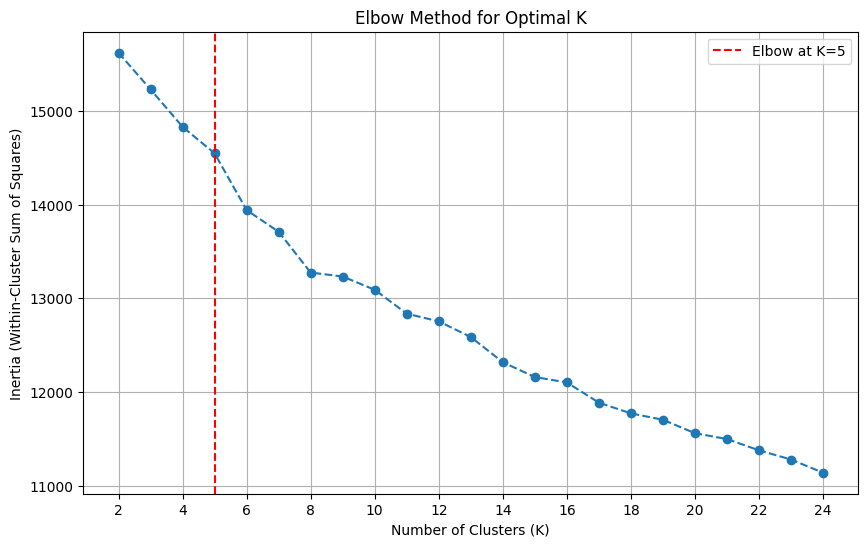

5

In [80]:
plot_elbow_curve(X_glove)

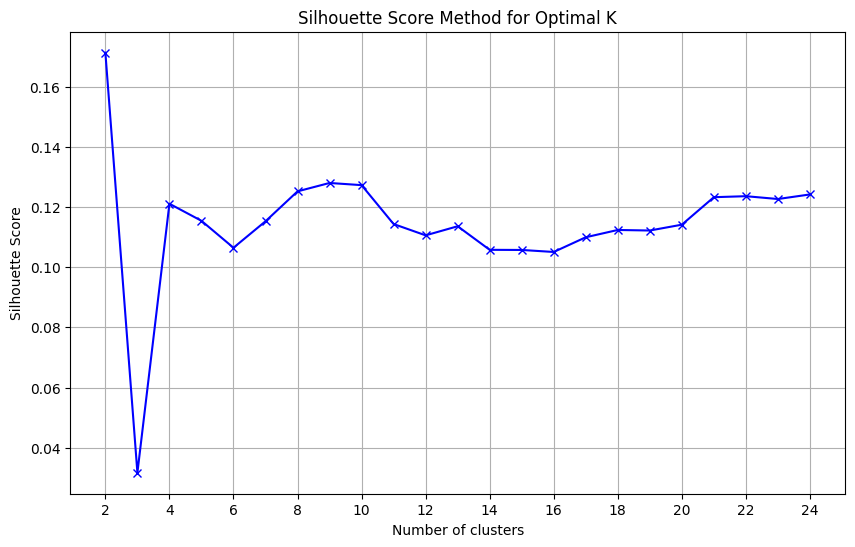

{2: 0.17133793653320997,
 3: 0.03165745062154419,
 4: 0.12111401593356166,
 5: 0.11543531091823574,
 6: 0.10648022600159003,
 7: 0.1152838526100132,
 8: 0.1252306721833959,
 9: 0.12802047997106036,
 10: 0.12729992978697924,
 11: 0.11436021494714495,
 12: 0.11060130284829056,
 13: 0.11362267142181033,
 14: 0.10578666852278297,
 15: 0.10574162450049542,
 16: 0.10507240028049825,
 17: 0.1099650144253437,
 18: 0.112391066543437,
 19: 0.11220648034325797,
 20: 0.11414781204222932,
 21: 0.12329246187755481,
 22: 0.12362265623777627,
 23: 0.12268368336653399,
 24: 0.1242031812307044}

In [82]:
plot_silhouette_scores(X_glove)

In [205]:
# Perform clustering and get results
cluster_labels_glove, inertia_value, sc_score, skill_to_cluster_id_glove = perform_kmeans_clustering(X_glove, unique_skills_list, K=5)

Inertia for K=5: 14545.483274561753
Silhouette Score for K=5: 0.11543531091823574


In [206]:
print_clusters_and_skills(skill_to_cluster_id_glove, K=5)

Cluster 0:
javascript/typescript, react, node.js, express.js, css3, aws, azure, testing, multitasking, tableau, power bi, architecture, ec2, s3, lambda, glue, athena, etl, spark, security, microservices, redux, typescript, react.js, analytics, golang, gcp, typescript/javascript, kafka, communication, leadership, ci/cd pipelines, jira, git, apache, docker, statistics, r, scheduling, graphql, angular, spring boot, j2ee, kubernetes, helm charts, azure devops, shell, maven, engineering, fastapi, tensorflow, pytorch, spacy, llms, transformers, programming, taxonomies, pl/sql, mapping, ppt, excel, clarity, jenkins, shell scripting, terraform, azure databricks, snowflake, automation, performance, scrum, kanban, agile, reporting, collaboration, analytical, problem-solving, es6+ javascript, hl7, figma, estimating, budgeting, confluence, containerization, rabbitmq, redis, c#, nosql, rest, soap, mongodb, elasticsearch, scala, spring, selenium, springboot, kotlin, reactjs, gradle, junit, nginx, sc

In [207]:
df_clustered_glove = df_skills.copy()
# df_clustered_glove['skill_cluster_ids'] = df_clustered_glove['skills'].apply(map_skills_to_clusters)
df_clustered_glove['skill_cluster_ids'] = df_clustered_glove['skills'].apply(
    lambda skills_list: map_skills_to_clusters(skills_list, skill_to_cluster_id_glove)
)

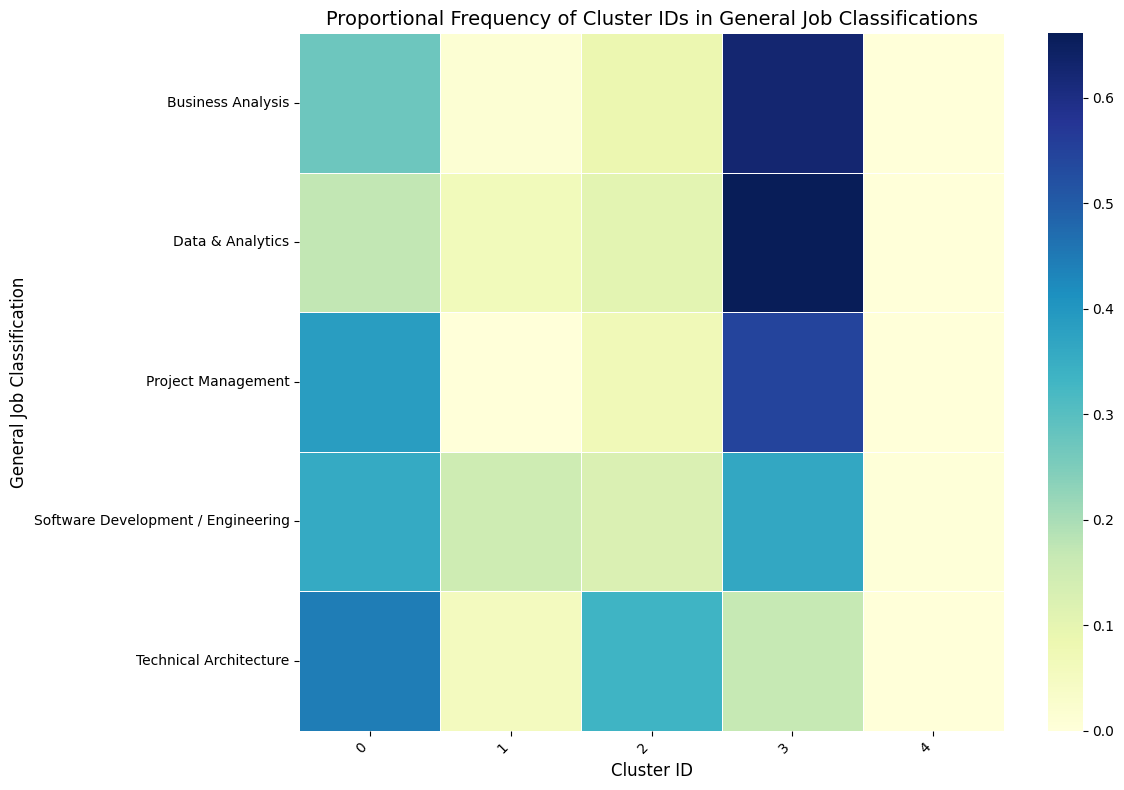

In [208]:
plot_cluster_heatmap(df_clustered_glove)

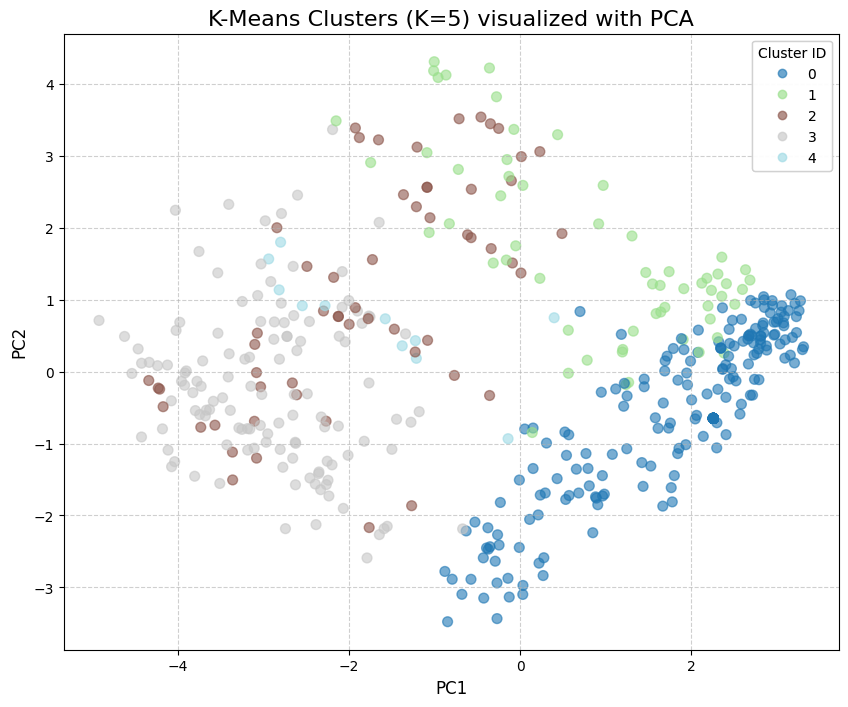

In [209]:
pca_df = reduce_dimensionality_pca(X_glove, cluster_labels_glove)
plot_2d_clusters_pca(df_to_plot=pca_df, k_clusters=5)

### BERT embedding

In [386]:
# Load pre-trained BERT model and tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertModel.from_pretrained('bert-base-uncased')

# Define a function to create BERT embeddings for a given skill
def bert_embedding(skill):
    """
    Converts a skill (sentence) into a BERT embedding.

    Args:
        skill (str): The input skill.

    Returns:
        np.ndarray: A vector representation of the skill.
    """
    # Tokenize the skill and convert to input IDs
    inputs = tokenizer(skill, return_tensors='pt', padding=True, truncation=True, max_length=50)
    
    # Get the BERT embeddings
    with torch.no_grad():
        outputs = model(**inputs)
    
    # Use the [CLS] token embedding as the sentence embedding
    cls_embedding = outputs.last_hidden_state[:, 0, :].squeeze(0).numpy()
    
    return cls_embedding

# Apply the BERT embedding function to the unique skills list
unique_skills_df = pd.DataFrame({'skill': unique_skills_list})  # Create a DataFrame for the skills
unique_skills_df['bert_embedding'] = unique_skills_df['skill'].apply(bert_embedding)

# Stack the embeddings into a matrix for clustering
X_bert = np.vstack(unique_skills_df['bert_embedding'])

print(f"Shape of BERT embeddings matrix: {X_bert.shape}")

Shape of BERT embeddings matrix: (3898, 768)


Elbow point detected at K = 7


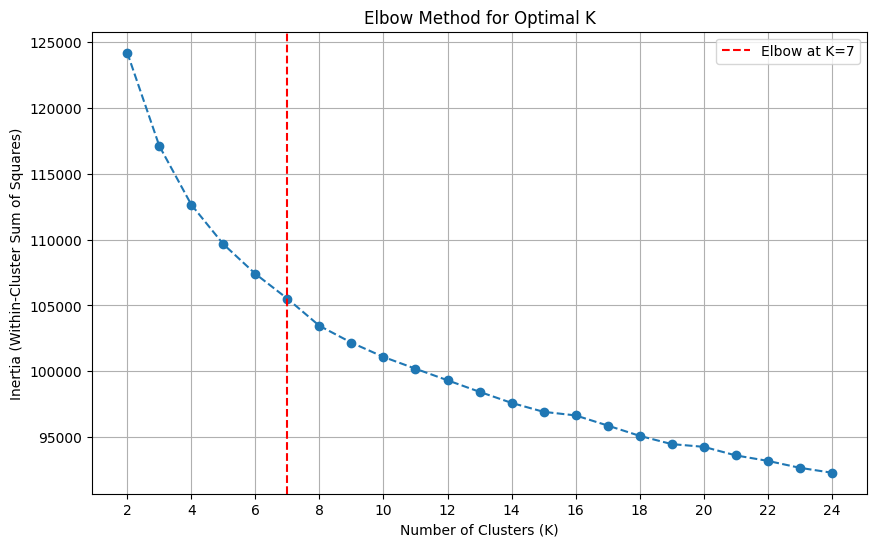

7

In [387]:
plot_elbow_curve(X_bert)

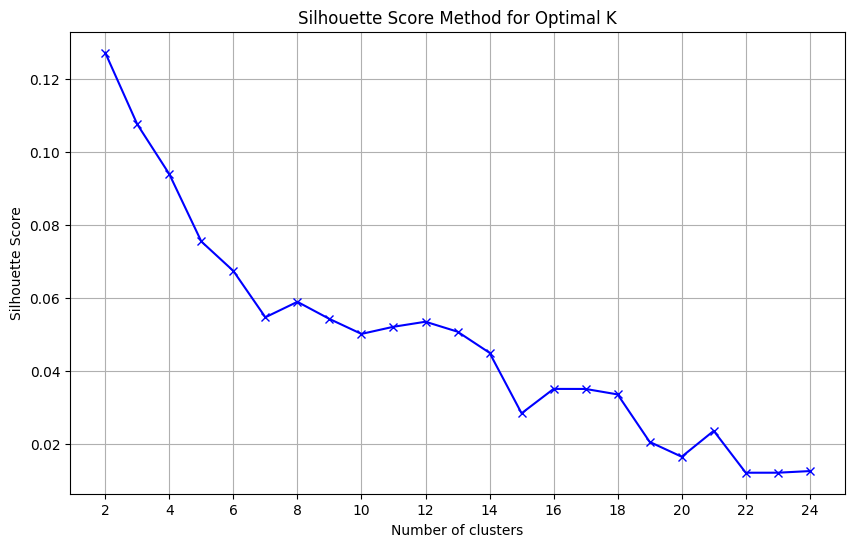

{2: 0.12727414071559906,
 3: 0.10764971375465393,
 4: 0.0940077155828476,
 5: 0.07553523033857346,
 6: 0.0674675852060318,
 7: 0.05476367473602295,
 8: 0.05899953842163086,
 9: 0.05431133136153221,
 10: 0.050202950835227966,
 11: 0.052163027226924896,
 12: 0.053543444722890854,
 13: 0.05081837624311447,
 14: 0.04502388834953308,
 15: 0.028444798663258553,
 16: 0.03513195738196373,
 17: 0.035118263214826584,
 18: 0.03361795097589493,
 19: 0.020603811368346214,
 20: 0.016541728749871254,
 21: 0.02363739348948002,
 22: 0.012159389443695545,
 23: 0.012163703329861164,
 24: 0.012610095553100109}

In [388]:
plot_silhouette_scores(X_bert)

In [389]:
# Perform clustering and get results
cluster_labels_bert, inertia_value, sc_score, skill_to_cluster_id_bert = perform_kmeans_clustering(X_bert, unique_skills_list, K=7)

Inertia for K=7: 105512.65625
Silhouette Score for K=7: 0.05476367473602295


In [390]:
print_clusters_and_skills(skill_to_cluster_id_bert, K=7)

Cluster 0:
continuous integration/continuous deployment (ci/cd) pipelines, api-based integration, smb and consumer tools, python-based software development, data manipulation libraries (pandas, numpy, matplotlib, plotly), restful apis, cloud platforms (aws/azure/databricks/snowflake/gcp), containers (docker/kubernetes), linux and windows platforms, ci/cd pipelines, version control (git or equivalent), data science (ai/ml) algorithms, message queues (kafka), scripting (powershell), azure resource management (arm) templates, object-oriented programming (oop), azure functions, excel functions, mvt (multi-value testing), data pipelines, sql queries, automated regression and integration test plans, tools and runtimes, service-oriented ui components, cloud-native technologies, serverless computing platforms, asp.net mvc or webforms, cloud architectures/services, enterprise resource planning (erp) software, micro-services architecture, domain driven design (ddd), behavior driven design (bdd),

In [391]:
df_clustered_bert = df_skills.copy()
# df_clustered_bert['skill_cluster_ids'] = df_clustered_bert['skills'].apply(map_skills_to_clusters)
df_clustered_bert['skill_cluster_ids'] = df_clustered_bert['skills'].apply(
    lambda skills_list: map_skills_to_clusters(skills_list, skill_to_cluster_id_bert)
)

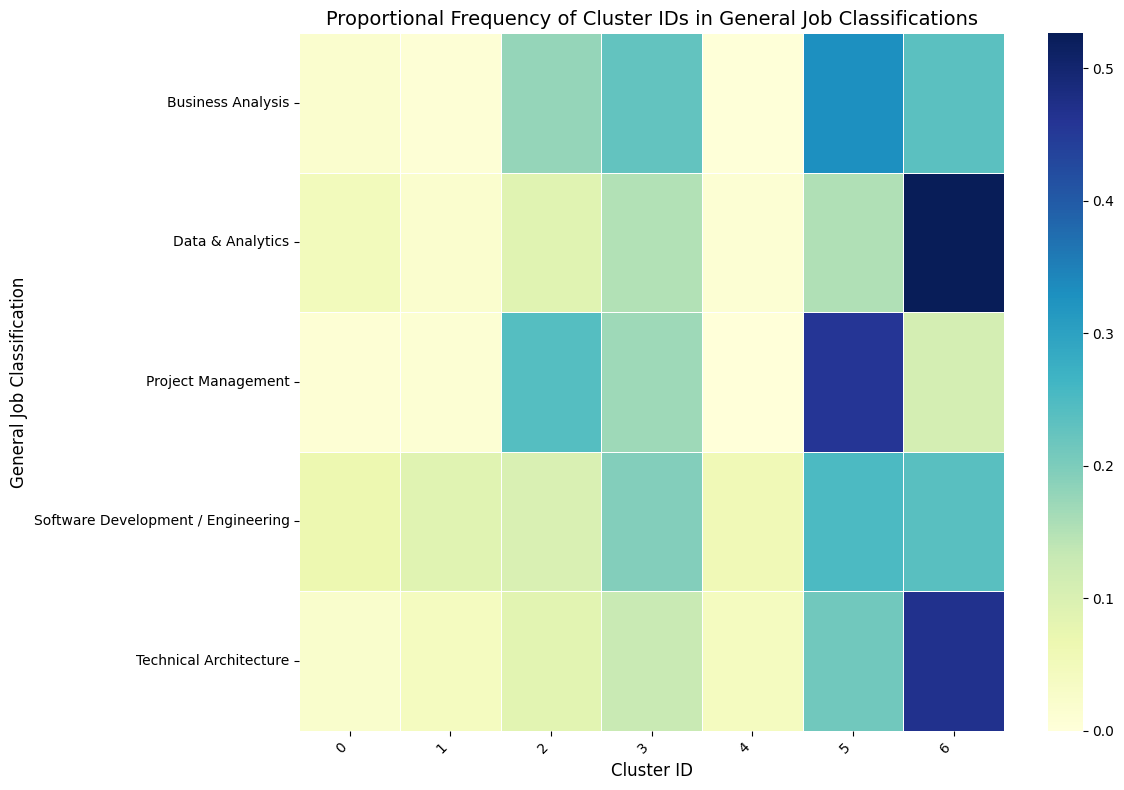

In [392]:
plot_cluster_heatmap(df_clustered_bert)

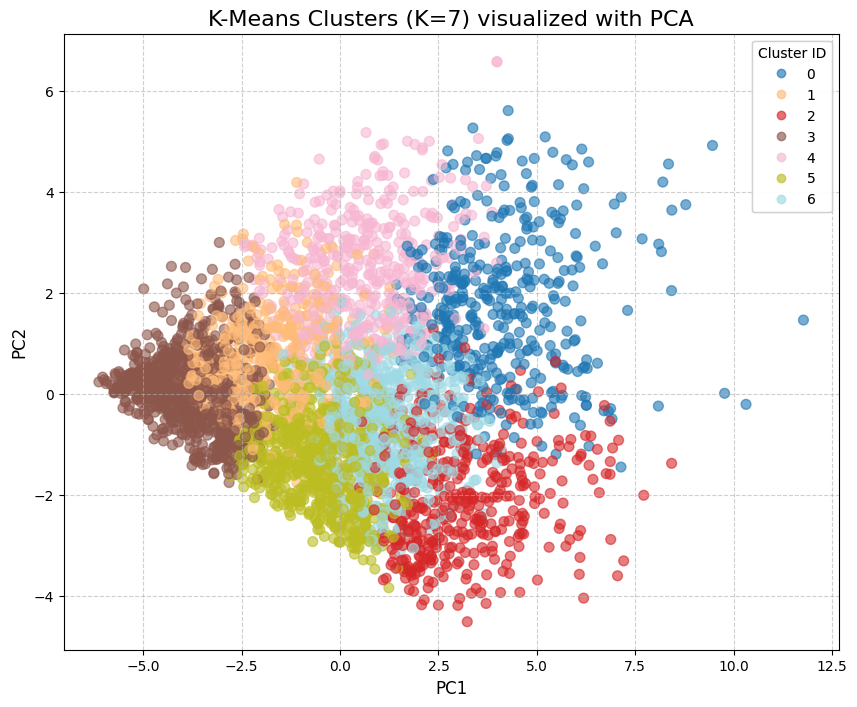

In [393]:
pca_df = reduce_dimensionality_pca(X_bert, cluster_labels_bert) # TODO ile zmiennosci wyjasnia PCA - ile variability wyjasnia PCA
plot_2d_clusters_pca(df_to_plot=pca_df, k_clusters=7)

### Creating features using one hot encoding for our model after embedding and clustering

We will be using the resulting dataframe from clustering performed after tf idf word embedding.

In [394]:
# count the most common skills in each cluster
def most_common_skills_per_cluster(df_clustered, skill_to_cluster_id, top_n=10):
    """
    Identifies the most common skills in each cluster.

    Args:
        df_clustered (pd.DataFrame): The DataFrame containing 'skills' and 'skill_cluster_ids'.
        skill_to_cluster_id (pd.Series): A mapping of skills to their cluster IDs.
        top_n (int): The number of top skills to return for each cluster.

    Returns:
        dict: A dictionary with cluster IDs as keys and lists of the most common skills as values.
    """
    cluster_skill_counter = {cluster_id: Counter() for cluster_id in skill_to_cluster_id.unique()}

    for _, row in df_clustered.iterrows():
        skills = row['skills']
        if not skills:
            continue
        for skill in skills:
            skill_lower = skill.lower()
            if skill_lower in skill_to_cluster_id:
                cluster_id = skill_to_cluster_id[skill_lower]
                cluster_skill_counter[cluster_id][skill_lower] += 1

    # Get the most common skills for each cluster
    most_common_skills = {
        cluster_id: [skill for skill, _ in counter.most_common(top_n)]
        for cluster_id, counter in cluster_skill_counter.items()
    }

    return most_common_skills

In [395]:
most_common_skills = most_common_skills_per_cluster(df_clustered_bert, skill_to_cluster_id_bert, top_n=10)
for cluster_id, skills in most_common_skills.items():
    print(f"Cluster {cluster_id}: {', '.join(skills)}")
    print("-" * 50)

Cluster 2: business analysis, software development, problem-solving, construction management, engineering, business intelligence, computer science, mechanical engineering, civil engineering, data engineering
--------------------------------------------------
Cluster 4: javascript, node.js, c++, postgresql, mysql, linux, microsoft office, azure devops, sql server, tensorflow
--------------------------------------------------
Cluster 3: sql, java, react, docker, communication, angular, excel, html, power bi, terraform
--------------------------------------------------
Cluster 1: python, aws, typescript, kubernetes, git, c#, tableau, css, r, spring boot
--------------------------------------------------
Cluster 6: project management, data analysis, machine learning, data visualization, data modeling, microservices, data science, data analytics, cloud computing, data warehousing
--------------------------------------------------
Cluster 5: analytical skills, documentation, communication sk

In [396]:
# what clusters are repeated across general job classification
# Create binary features for each cluster
def create_cluster_features(cluster_ids, K):
    features = np.zeros(K)
    for cid in cluster_ids:
        if cid is not None and 0 <= cid < K:
            features[cid] = 1
    return features
cluster_features = df_clustered_bert['skill_cluster_ids'].apply(lambda ids: create_cluster_features(ids, K=7))


Generate Count Features: Use one-hot encoding or counting to create a feature for each cluster category. This is the final, most valuable feature set for your prediction model.

In [397]:
cluster_counts = df_clustered_bert.explode('skill_cluster_ids').groupby(level=0)['skill_cluster_ids'].value_counts()
cluster_features = cluster_counts.unstack(fill_value=0)
cluster_features = cluster_features.reindex(df_clustered_bert.index, fill_value=0) # Ensure the index matches
df_clustered_bert = df_clustered_bert.join(cluster_features)

## Understanding sentiment in job descriptions

We will use VADER Analysis  (Valence Aware Dictionary and sEntiment Reasoner)

In [ ]:
!pip install nltk

In [ ]:
nltk.download('vader_lexicon')

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/juliabarsow/nltk_data...


True

In [398]:
analyzer = SentimentIntensityAnalyzer()

def get_sentiment(text):
    scores = analyzer.polarity_scores(text)
    return scores['compound']

df_clustered_bert['sentiment'] = df_clustered_bert['description'].apply(get_sentiment)

In [ ]:
# scaling sentiment scores to introduce more variablity
df_clustered_bert['scaled_sentiment'] = -np.log10(1 - df_clustered_bert['sentiment'])

In [ ]:
df_clustered_bert['scaled_sentiment'].describe()

count    840.000000
mean       1.957547
std        0.807959
min       -0.000000
25%        1.380646
50%        2.045757
75%        2.619789
max        3.698970
Name: scaled_sentiment, dtype: float64

In [335]:
df_clustered_tfidf.head()

,job_id,title,description,general job classification,skills,formal_requirements,skill_cluster_ids,0,1,2,3,4,5,sentiment,scaled_sentiment
0,2234533717,Full Stack Engineer,"Location: Remote\nCompany Overview:SkillFit, a...",Software Development / Engineering,"[full-stack web development, JavaScript/TypeSc...",[3+ years of professional experience in softwa...,"[0, 0, 0, 0, 0, 0, 0]",7,0,0,0,0,0,0.9989,2.958607
1,2269442456,Computer Scientist,Are you passionate about developing cutting-ed...,Software Development / Engineering,"[software development, deep space communicatio...",[Bachelor's degree in Computer Science or rela...,"[0, 0, 0, 0]",4,0,0,0,0,0,0.9853,1.832683
2,2314566469,Front end specialist,Regional law firm looking for a candidate with...,Software Development / Engineering,"[phone sales, customer service, interpersonal ...","[superior phone sales experience, passion for ...","[0, 0, 0, 0, 0, 0, 0, 0]",8,0,0,0,0,0,0.9665,1.474955
3,2735151240,Intern- Business Analytics,Summer Internshipadidas & Carhartt kids Divisi...,Data & Analytics,"[data analysis, modeling, visualization, Micro...","[MBA program with a focus in data analytics, P...","[5, 0, 0]",2,0,0,0,0,1,0.9965,2.455932
4,3045980831,Project Engineer,JOB DESCRIPTION:The Project Engineer assists t...,Project Management,"[Construction/Civil Engineering, Architecture,...",[Bachelor's degree in Construction/Civil Engin...,[],0,0,0,0,0,0,0.8779,0.913284


## Job Posting Success Prediction

In [399]:
# Columns from original dataset to keep for prediction
columns_to_keep = [
    'formatted_work_type',
    'views',
    'job_id'
]

In [400]:
# columns to keep from clustered dataset
clustered_columns_to_keep = [
    'general job classification',
    # 'scaled_sentiment',
    'description',
    'job_id'
] + list(range(7))  # Add cluster count columns (0 to K)

In [401]:
# Merge selected clustered word embeddings dataframe with selected columns from original data
final_df = df_clustered_bert[clustered_columns_to_keep].merge(data[columns_to_keep], on='job_id', how='left')

In [402]:
# rename numeric cluster columns to have a prefix
final_df.rename(columns={i: f'cluster_{i}' for i in range(7)}, inplace=True)

In [403]:
# drop rows where viewes is missing
final_df = final_df.dropna(subset=['views'])

In [404]:
final_df.head()

,general job classification,description,job_id,cluster_0,cluster_1,cluster_2,cluster_3,cluster_4,cluster_5,cluster_6,formatted_work_type,views
0,Software Development / Engineering,"Location: Remote\nCompany Overview:SkillFit, a...",2234533717,0,0,1,1,1,1,3,Full-time,21.0
2,Software Development / Engineering,Regional law firm looking for a candidate with...,2314566469,0,0,0,1,0,6,1,Full-time,3.0
3,Data & Analytics,Summer Internshipadidas & Carhartt kids Divisi...,2735151240,0,0,0,1,0,0,2,Temporary,5.0
4,Project Management,JOB DESCRIPTION:The Project Engineer assists t...,3045980831,0,0,0,0,0,0,0,Full-time,4.0
5,Data & Analytics,Request: Data ArchitectLocation: San Francisco...,3245063922,0,0,0,0,0,0,0,Contract,7.0


In [405]:
# Define the labels for your bins - we predict is job posting is successful or not
bin_labels = ['Bin 1: Lowest 25%', 'Bin 2: Low-Medium (25-50%)', 'Bin 3: Medium-High (50-75%)', 'Bin 4: Highest 25%']

# Use pd.qcut to create 4 equal-frequency bins
# 'q=4' specifies 4 bins (quartiles)
final_df['views_bin'] = pd.qcut(
    x=final_df['views'],
    q=4,
    labels=bin_labels,
    duplicates='drop'  # Handles cases where quartiles are identical
)

# Check the distribution
print("Bin Boundaries (The Quantiles):")
print(final_df['views_bin'].cat.codes.value_counts())
print("\nViews Bins Distribution:")
print(final_df['views_bin'].value_counts(normalize=True))

Bin Boundaries (The Quantiles):
0    268
3    205
2    198
1    151
Name: count, dtype: int64

Views Bins Distribution:
views_bin
Bin 1: Lowest 25%              0.326034
Bin 4: Highest 25%             0.249392
Bin 3: Medium-High (50-75%)    0.240876
Bin 2: Low-Medium (25-50%)     0.183698
Name: proportion, dtype: float64


In [406]:
from sklearn.model_selection import train_test_split

cluster_cols = [f'cluster_{i}' for i in range(0, 7)]

X = final_df[cluster_cols + [ 'formatted_work_type', 'general job classification']]
y = final_df['views_bin']

# Use stratify=y to maintain class proportions in train and test sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    random_state=0,
    train_size=0.8,
    stratify=y
)

print('Size of training set = %d and test set = %d' % (y_train.size, y_test.size))

Size of training set = 657 and test set = 165


In [407]:
# One-hot encode categorical features
col_dummny = ['formatted_work_type',  'general job classification']
numeric_cols = [col for col in X.columns if col not in col_dummny]
# Initialize the OneHotEncoder within a ColumnTransformer
# The 'handle_unknown="ignore"' tells the encoder to ignore (set to 0) 
# any categories in the test set that were not seen in the training set.
# 'drop='first'' mimics the behavior of drop_first=True in pd.get_dummies
preprocessor = ColumnTransformer(
    transformers=[
        ('onehot', 
         OneHotEncoder(handle_unknown='ignore', sparse_output=False, drop='first'), 
         col_dummny),
         ('scaler',  MinMaxScaler(), numeric_cols)
    ],
    remainder='passthrough' # Keep other columns as they are
)

# FIT the preprocessor ONLY on the training data
preprocessor.fit(X_train)

# TRANSFORM both the training and test data
X_train_encoded = preprocessor.transform(X_train)
X_test_encoded = preprocessor.transform(X_test)

# Convert the resulting NumPy arrays back to DataFrames for modeling, 
# ensuring consistent column names.
feature_names = preprocessor.get_feature_names_out()

# Create DataFrames with the new column names
X_train = pd.DataFrame(X_train_encoded, columns=feature_names, index=X_train.index)
X_test = pd.DataFrame(X_test_encoded, columns=feature_names, index=X_test.index)

In [408]:
feature_names

array(['onehot__formatted_work_type_Full-time',
       'onehot__formatted_work_type_Internship',
       'onehot__formatted_work_type_Other',
       'onehot__formatted_work_type_Part-time',
       'onehot__formatted_work_type_Temporary',
       'onehot__general job classification_Data & Analytics',
       'onehot__general job classification_Project Management',
       'onehot__general job classification_Software Development / Engineering',
       'onehot__general job classification_Technical Architecture',
       'scaler__cluster_0', 'scaler__cluster_1', 'scaler__cluster_2',
       'scaler__cluster_3', 'scaler__cluster_4', 'scaler__cluster_5',
       'scaler__cluster_6'], dtype=object)

### Naive Bayes Classifier

In [409]:
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Initialize the Naive Bayes classifier
nb_model = GaussianNB()

# Fit the model on the training data
nb_model.fit(X_train, y_train)

# Make predictions on training and test data
y_train_pred = nb_model.predict(X_train)
y_test_pred = nb_model.predict(X_test)

# Training performance
train_accuracy = accuracy_score(y_train, y_train_pred)
print(f"Training Accuracy: {train_accuracy:.4f}")
print("Training Classification Report:")
print(classification_report(y_train, y_train_pred))

# Test performance
test_accuracy = accuracy_score(y_test, y_test_pred)
print(f"Test Accuracy: {test_accuracy:.4f}")
print("Test Classification Report:")
print(classification_report(y_test, y_test_pred))

# Confusion matrix for test set
print("Test Confusion Matrix:")
print(confusion_matrix(y_test, y_test_pred))

Training Accuracy: 0.2146
Training Classification Report:
                             precision    recall  f1-score   support

          Bin 1: Lowest 25%       0.47      0.09      0.16       214
 Bin 2: Low-Medium (25-50%)       0.19      0.95      0.32       121
Bin 3: Medium-High (50-75%)       0.00      0.00      0.00       158
         Bin 4: Highest 25%       0.30      0.04      0.07       164

                   accuracy                           0.21       657
                  macro avg       0.24      0.27      0.14       657
               weighted avg       0.26      0.21      0.13       657

Test Accuracy: 0.2000
Test Classification Report:
                             precision    recall  f1-score   support

          Bin 1: Lowest 25%       0.40      0.07      0.12        54
 Bin 2: Low-Medium (25-50%)       0.19      0.93      0.32        30
Bin 3: Medium-High (50-75%)       0.00      0.00      0.00        40
         Bin 4: Highest 25%       0.12      0.02      0.04  

/Users/juliabarsow/Desktop/thesis/project_code/NLP_Job_Postings/.venv/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/Users/juliabarsow/Desktop/thesis/project_code/NLP_Job_Postings/.venv/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/Users/juliabarsow/Desktop/thesis/project_code/NLP_Job_Postings/.venv/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted sa

### Random Forest Classifier

In [410]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

# Initialize the Random Forest Classifier
rf_model = RandomForestClassifier(class_weight='balanced', random_state=42)

# Grid of parameters to choose from
parameters = {
    "max_depth": [5, 10, 15, 20, 30, 40, None],
    "max_leaf_nodes": [None, 50, 100, 200],
    "min_samples_split": [2, 10, 30],
    'min_samples_split': [2, 5, 10],
    'criterion': ['gini', 'entropy']
}

# Run the grid search
grid_obj = GridSearchCV(rf_model, parameters, cv=5,scoring='f1_weighted',n_jobs=-1)
grid_obj = grid_obj.fit(X_train, y_train)

# Set the clf to the best combination of parameters
rf_model = grid_obj.best_estimator_

# Train the Model
print("Training Random Forest Classifier...")
rf_model.fit(X_train, y_train)
print("Training Complete.")

Training Random Forest Classifier...
Training Complete.


In [411]:
# print parameters of rf model
print("Best parameters found:", grid_obj.best_params_)
print("Best cross-validation score:", grid_obj.best_score_)
print("Best estimator:", grid_obj.best_estimator_)

Best parameters found: {'criterion': 'entropy', 'max_depth': 20, 'max_leaf_nodes': None, 'min_samples_split': 10}
Best cross-validation score: 0.3883540947643104
Best estimator: RandomForestClassifier(class_weight='balanced', criterion='entropy',
                       max_depth=20, min_samples_split=10, random_state=42)


<Axes: >

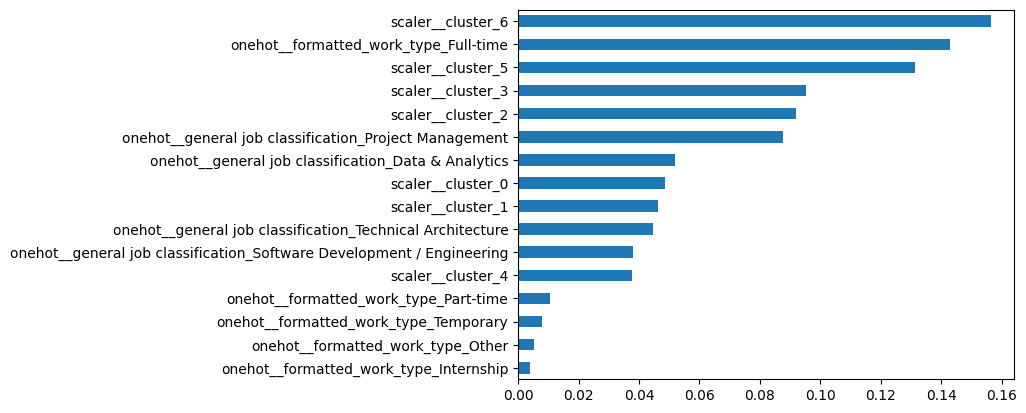

In [412]:
feat_importances = pd.Series(rf_model.feature_importances_, index = X_train.columns).sort_values(ascending = True)
feat_importances.plot(kind = 'barh') # TODO: WYJEBAC SENTYMRNT

In [413]:
# Make Predictions on the Test Set
y_pred = rf_model.predict(X_test)

# Calculate Overall Accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"\nOverall Test Accuracy: {accuracy:.4f}\n")

# Print the Classification Report
print("--- Classification Report ---")
print(classification_report(y_test, y_pred))

# Print the Confusion Matrix
# This shows exactly how many times the model confused one bin for another.
# Rows are the TRUE bins; Columns are the PREDICTED bins.
print("\n--- Confusion Matrix ---")
print(confusion_matrix(y_test, y_pred))


Overall Test Accuracy: 0.2727

--- Classification Report ---
                             precision    recall  f1-score   support

          Bin 1: Lowest 25%       0.31      0.39      0.35        54
 Bin 2: Low-Medium (25-50%)       0.12      0.07      0.09        30
Bin 3: Medium-High (50-75%)       0.21      0.23      0.22        40
         Bin 4: Highest 25%       0.34      0.32      0.33        41

                   accuracy                           0.27       165
                  macro avg       0.25      0.25      0.24       165
               weighted avg       0.26      0.27      0.26       165


--- Confusion Matrix ---
[[21  5 17 11]
 [14  2  7  7]
 [18  6  9  7]
 [14  4 10 13]]


### SVM

In [417]:
# Using a pipeline to classify
# pipeline = Pipeline([
#     ('svm', SVC(random_state=42)) # TODO: AIC (Akaike Information Criterion), roc/auc curve 5600-10000 model do wyjebania, 2700 w dol jest super
# ])
from sklearn.metrics import mean_squared_error
svm_model = SVC(random_state=42)

param_grid = {
    'C': [0.1, 1, 10],
    'kernel': ['linear', 'rbf', 'poly'], 
    'gamma': ['scale', 'auto']      
}

grid = GridSearchCV(svm_model, param_grid, scoring='f1_macro', cv=5, n_jobs=-1)
grid.fit(X_train, y_train)

# Set the best combination of parameters
svm_model = grid.best_estimator_

print("Best parameters:", grid.best_params_)
print("Best cross-validation score:", grid.best_score_)

# Train the Model
print("Training SVM...")
svm_model.fit(X_train, y_train)
print("Training Complete.")



Best parameters: {'C': 1, 'gamma': 'scale', 'kernel': 'rbf'}
Best cross-validation score: 0.3251628273320346
Training SVM...
Training Complete.


In [422]:
# Train results
y_pred_train = svm_model.predict(X_train)
accuracy = accuracy_score(y_train, y_pred_train)

print(f"\nOverall Train Accuracy: {accuracy:.4f}\n")
print(classification_report(y_train, y_pred_train))
print(confusion_matrix(y_train, y_pred_train))

# Test results
y_pred = svm_model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)

print(f"\nOverall Test Accuracy: {accuracy:.4f}\n")
print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))


Overall Train Accuracy: 0.4399

                             precision    recall  f1-score   support

          Bin 1: Lowest 25%       0.44      0.76      0.56       214
 Bin 2: Low-Medium (25-50%)       1.00      0.01      0.02       121
Bin 3: Medium-High (50-75%)       0.36      0.23      0.28       158
         Bin 4: Highest 25%       0.48      0.55      0.51       164

                   accuracy                           0.44       657
                  macro avg       0.57      0.39      0.34       657
               weighted avg       0.53      0.44      0.38       657

[[162   0  23  29]
 [ 77   1  18  25]
 [ 78   0  36  44]
 [ 52   0  22  90]]

Overall Test Accuracy: 0.3273

                             precision    recall  f1-score   support

          Bin 1: Lowest 25%       0.34      0.59      0.44        54
 Bin 2: Low-Medium (25-50%)       0.00      0.00      0.00        30
Bin 3: Medium-High (50-75%)       0.23      0.17      0.20        40
         Bin 4: Highest 25

/Users/juliabarsow/Desktop/thesis/project_code/NLP_Job_Postings/.venv/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/Users/juliabarsow/Desktop/thesis/project_code/NLP_Job_Postings/.venv/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/Users/juliabarsow/Desktop/thesis/project_code/NLP_Job_Postings/.venv/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted sa

### Logistic Regression and GLM

In [423]:
multi_class='multinomial'
solver='lbfgs'  # or 'saga' for large datasets

# Pipeline for GLM
pipeline = Pipeline([
    ('glm', LogisticRegression(
        multi_class='multinomial',
        solver='lbfgs',
        max_iter=1000,
        random_state=42,
        fit_intercept=True
    ))
])


pipeline.fit(X_train, y_train)

y_pred_train = pipeline.predict(X_train)
y_prob_train = pipeline.predict_proba(X_train)  # <-- class probabilities!
accuracy_train = accuracy_score(y_train, y_pred_train)

y_pred = pipeline.predict(X_test)
y_prob = pipeline.predict_proba(X_test)  # <-- class probabilities!
accuracy = accuracy_score(y_test, y_pred)

print(f"\nOverall Train Accuracy: {accuracy_train:.4f}\n")
print("Classification report:")
print(classification_report(y_train, y_pred_train))


print(f"\nOverall Test Accuracy: {accuracy:.4f}\n")
print("Classification report:")
print(classification_report(y_test, y_pred))



Overall Train Accuracy: 0.4231

Classification report:
                             precision    recall  f1-score   support

          Bin 1: Lowest 25%       0.41      0.80      0.54       214
 Bin 2: Low-Medium (25-50%)       0.00      0.00      0.00       121
Bin 3: Medium-High (50-75%)       0.39      0.11      0.17       158
         Bin 4: Highest 25%       0.48      0.55      0.51       164

                   accuracy                           0.42       657
                  macro avg       0.32      0.36      0.30       657
               weighted avg       0.34      0.42      0.34       657


Overall Test Accuracy: 0.3152

Classification report:
                             precision    recall  f1-score   support

          Bin 1: Lowest 25%       0.32      0.65      0.43        54
 Bin 2: Low-Medium (25-50%)       0.00      0.00      0.00        30
Bin 3: Medium-High (50-75%)       0.20      0.07      0.11        40
         Bin 4: Highest 25%       0.36      0.34      0.3

/Users/juliabarsow/Desktop/thesis/project_code/NLP_Job_Postings/.venv/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


In [424]:
probs_df = pd.DataFrame(y_prob, columns=pipeline.named_steps['glm'].classes_)
print(probs_df.head())

   Bin 1: Lowest 25%  Bin 2: Low-Medium (25-50%)  Bin 3: Medium-High (50-75%)  \
0           0.323561                    0.258177                     0.226353   
1           0.541049                    0.150885                     0.285447   
2           0.317805                    0.256723                     0.216219   
3           0.317805                    0.256723                     0.216219   
4           0.294948                    0.168271                     0.308595   

   Bin 4: Highest 25%  
0            0.191909  
1            0.022619  
2            0.209252  
3            0.209252  
4            0.228185  


### Ensemble of Random Forest, SVM and GLM

In [425]:
# Get probabilities from the GLM step
glm_probs = pipeline.named_steps['glm'].predict_proba(X_test)

# Get predicted classes
glm_preds = pipeline.named_steps['glm'].classes_[np.argmax(glm_probs, axis=1)]

# Predictions from other models
# 1. Predictions from all models
rf_preds = rf_model.predict(X_test)
svm_preds = grid.best_estimator_.predict(X_test)

# GLM probabilities -> predicted classes
# X_test_scaled = pipeline.named_steps['scaler'].transform(X_test)
glm_probs = pipeline.named_steps['glm'].predict_proba(X_test)
glm_preds = pipeline.named_steps['glm'].classes_[np.argmax(glm_probs, axis=1)]

# 2. Combine predictions
all_preds = np.vstack([rf_preds, svm_preds, glm_preds]).T  # shape: (n_samples, 3)

# 3. Majority vote function for string labels
def majority_vote(row):
    vals, counts = np.unique(row, return_counts=True)
    return vals[np.argmax(counts)]

final_preds = np.apply_along_axis(majority_vote, axis=1, arr=all_preds)

# 4. Optional: inspect
ensemble_df = pd.DataFrame({
    'RF': rf_preds,
    'SVM': svm_preds,
    'GLM': glm_preds,
    'Final_Vote': final_preds
})
print(ensemble_df.head())

# 5. Evaluate
print("Ensemble Accuracy:", accuracy_score(y_test, final_preds))
print(classification_report(y_test, final_preds))

                            RF                          SVM  \
0  Bin 3: Medium-High (50-75%)            Bin 1: Lowest 25%   
1            Bin 1: Lowest 25%            Bin 1: Lowest 25%   
2   Bin 2: Low-Medium (25-50%)            Bin 1: Lowest 25%   
3   Bin 2: Low-Medium (25-50%)            Bin 1: Lowest 25%   
4  Bin 3: Medium-High (50-75%)  Bin 3: Medium-High (50-75%)   

                           GLM         Final_Vote  
0            Bin 1: Lowest 25%  Bin 1: Lowest 25%  
1            Bin 1: Lowest 25%  Bin 1: Lowest 25%  
2            Bin 1: Lowest 25%  Bin 1: Lowest 25%  
3            Bin 1: Lowest 25%  Bin 1: Lowest 25%  
4  Bin 3: Medium-High (50-75%)  Bin 3: Medium-Hig  
Ensemble Accuracy: 0.19393939393939394
                             precision    recall  f1-score   support

          Bin 1: Lowest 25%       0.34      0.59      0.44        54
          Bin 2: Low-Medium       0.00      0.00      0.00         0
 Bin 2: Low-Medium (25-50%)       0.00      0.00      0.00    

/Users/juliabarsow/Desktop/thesis/project_code/NLP_Job_Postings/.venv/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/Users/juliabarsow/Desktop/thesis/project_code/NLP_Job_Postings/.venv/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/Users/juliabarsow/Desktop/thesis/project_code/NLP_Job_Postings/.venv/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. U

### LDA FOR JOB SUCCESS PREDICTION

/Users/juliabarsow/Desktop/thesis/project_code/NLP_Job_Postings/.venv/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/Users/juliabarsow/Desktop/thesis/project_code/NLP_Job_Postings/.venv/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:473: ConvergenceWarning: lbfgs failed to converge after 100 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=100).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


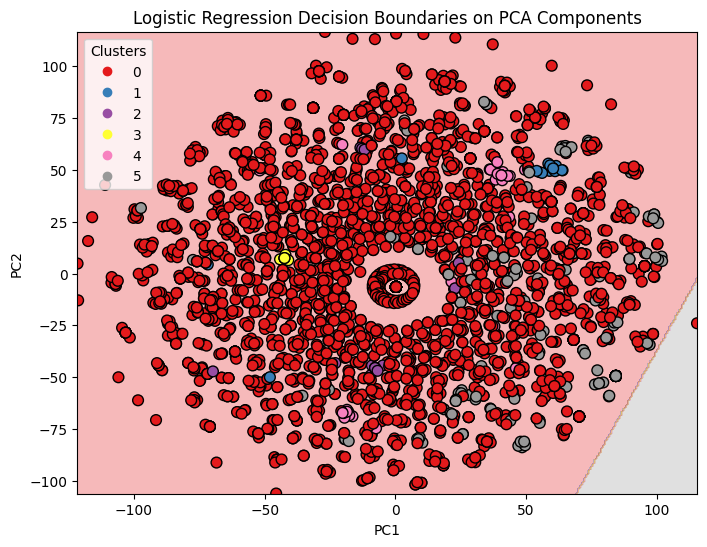

In [ ]:
# We use the already prepared tsne_df from previous t-SNE reduction step on TF-IDF vectors
X = tsne_df[['TSNE_1', 'TSNE_2']].values
y = tsne_df['Cluster'].values


# Fit the logistic regression model
model = LogisticRegression(multi_class='multinomial', solver='lbfgs')
model.fit(X, y)

# Create a grid of points that covers the PCA feature space
x_min, x_max = X[:, 0].min() - 0.1, X[:, 0].max() + 0.1
y_min, y_max = X[:, 1].min() - 0.1, X[:, 1].max() + 0.1
xx, yy = np.meshgrid(np.linspace(x_min, x_max, 300),
                     np.linspace(y_min, y_max, 300))

# Predict cluster labels for each grid point
Z = model.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

# Plot the decision boundaries
plt.figure(figsize=(8, 6))
plt.contourf(xx, yy, Z, alpha=0.3, cmap='Set1')

# Overlay the actual PCA points
scatter = plt.scatter(X[:, 0], X[:, 1], c=y, cmap='Set1', edgecolor='k', s=60)
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('Logistic Regression Decision Boundaries on PCA Components')

# Add legend for cluster labels
plt.legend(*scatter.legend_elements(), title="Clusters")
plt.show()


In [356]:
# If 'skills' column contains string representations of lists, convert them:
def clean_skills(x):
    if isinstance(x, str):
        try:
            # convert stringified list to list
            x = ast.literal_eval(x)
        except:
            pass
    if isinstance(x, list):
        return " ".join(x)
    return str(x)

df = df_clustered_tfidf.copy()
df['skills_clean'] = df['skills'].apply(clean_skills)

# --- Step 2: Create TF-IDF matrix ---
# tfidf_vectorizer = TfidfVectorizer(
#     max_df=0.95,
#     min_df=2,
#     stop_words='english'
# )
tfidf_matrix = vectorizer.fit_transform(df['skills_clean'])

# --- Step 3: Perform LDA ---
n_topics = 5  # you can tune this number based on coherence or domain knowledge
lda = LatentDirichletAllocation(
    n_components=n_topics,
    random_state=42
)
lda_topics = lda.fit_transform(tfidf_matrix)

# --- Step 4: Add topic distributions as new columns ---
for i in range(n_topics):
    df[f'topic_{i+1}'] = lda_topics[:, i]

# --- Step 5: (Optional) Inspect top words per topic ---
def get_top_words(model, feature_names, n_top_words):
    topics = {}
    for topic_idx, topic in enumerate(model.components_):
        top_features = [feature_names[i] for i in topic.argsort()[:-n_top_words - 1:-1]]
        topics[f'Topic_{topic_idx+1}'] = top_features
    return topics

top_words = get_top_words(lda, vectorizer.get_feature_names_out(), 10)

print("Top words per topic:")
for topic, words in top_words.items():
    print(f"{topic}: {', '.join(words)}")

# --- Step 6: View updated dataframe ---
print(df.head())

Top words per topic:
Topic_1: construction, engineering, react, typescript, computer, js, science, civil, scheduling, cost
Topic_2: java, aws, kubernetes, docker, cloud, python, angular, spring, net, azure
Topic_3: management, project, business, analysis, communication, skills, and, process, office, engineering
Topic_4: data, development, design, javascript, sql, python, cloud, database, software, programming
Topic_5: data, sql, python, tableau, power, excel, bi, visualization, analysis, analytics
       job_id                       title  \
0  2234533717         Full Stack Engineer   
1  2269442456          Computer Scientist   
2  2314566469        Front end specialist   
3  2735151240  Intern- Business Analytics   
4  3045980831            Project Engineer   

                                         description  \
0  Location: Remote\nCompany Overview:SkillFit, a...   
1  Are you passionate about developing cutting-ed...   
2  Regional law firm looking for a candidate with...   
3 

In [358]:
df = df.merge(final_df[['job_id', 'formatted_work_type',  'views_bin']])
# cluster_cols = [f'cluster_{i}_count' for i in range(0, K)]
cluster_count = [i for i in range(0, 7)]
lda_cols = [f'topic_{i}' for i in range(1, 6)]

X = df[ lda_cols + ['scaled_sentiment', 'formatted_work_type', 'general job classification']]
y = df['views_bin']

# Use stratify=y to maintain class proportions in train and test sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    random_state=0,
    train_size=0.8,
    stratify=y
)

print('Size of training set = %d and test set = %d' % (y_train.size, y_test.size))

Size of training set = 657 and test set = 165


In [359]:
# One-hot encode categorical features
col_dummny = ['formatted_work_type',  'general job classification']
numeric_cols = [col for col in X.columns if col not in col_dummny]
# 1. Initialize the OneHotEncoder within a ColumnTransformer
# The 'handle_unknown="ignore"' tells the encoder to ignore (set to 0) 
# any categories in the test set that were not seen in the training set.
# 'drop='first'' mimics the behavior of drop_first=True in pd.get_dummies
preprocessor = ColumnTransformer(
    transformers=[
        ('onehot', 
         OneHotEncoder(handle_unknown='ignore', sparse_output=False, drop='first'), 
         col_dummny),
         ('scaler',  MinMaxScaler(), numeric_cols)
    ],
    remainder='passthrough' # Keep other columns as they are
)

# 2. FIT the preprocessor ONLY on the training data
preprocessor.fit(X_train)

# 3. TRANSFORM both the training and test data
X_train_encoded = preprocessor.transform(X_train)
X_test_encoded = preprocessor.transform(X_test)

# Convert the resulting NumPy arrays back to DataFrames for modeling, 
# ensuring consistent column names.
feature_names = preprocessor.get_feature_names_out()

# Create DataFrames with the new column names
X_train = pd.DataFrame(X_train_encoded, columns=feature_names, index=X_train.index)
X_test = pd.DataFrame(X_test_encoded, columns=feature_names, index=X_test.index)

In [360]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

# Initialize the Random Forest Classifier
rf_model = RandomForestClassifier(class_weight='balanced', random_state=42)

# Grid of parameters to choose from
parameters = {
    "max_depth": [5, 10, 15, 20, 30, 40, None],
    "max_leaf_nodes": [None, 50, 100, 200],
    "min_samples_split": [2, 10, 30],
    'min_samples_split': [2, 5, 10],
    'criterion': ['gini', 'entropy']
}

# Run the grid search
grid_obj = GridSearchCV(rf_model, parameters, cv=5,scoring='f1_weighted',n_jobs=-1)
grid_obj = grid_obj.fit(X_train, y_train)

# Set the clf to the best combination of parameters
rf_model = grid_obj.best_estimator_

# Train the Model
print("Training Random Forest Classifier...")
rf_model.fit(X_train, y_train)
print("Training Complete.")

# print parameters of rf model
print("Best parameters found:", grid_obj.best_params_)
print("Best cross-validation score:", grid_obj.best_score_)
print("Best estimator:", grid_obj.best_estimator_)

Training Random Forest Classifier...
Training Complete.
Best parameters found: {'criterion': 'entropy', 'max_depth': 10, 'max_leaf_nodes': 50, 'min_samples_split': 5}
Best cross-validation score: 0.35972531619080966
Best estimator: RandomForestClassifier(class_weight='balanced', criterion='entropy',
                       max_depth=10, max_leaf_nodes=50, min_samples_split=5,
                       random_state=42)
